# **MODULE DE PREPROCESSING**

## **1. Collecte et indexation des proformas**

Cette étape permet de construire une liste claire et traçable des fichiers proformas disponibles, en attribuant à chaque fichier un identifiant unique (hash) et en enregistrant ses informations techniques (nom, taille, chemin). Cet inventaire servira de base de référence pour suivre les documents analysés, détecter les doublons, et faciliter les audits de traitement.

In [3]:
# 1.1 Configuration des chemins
from pathlib import Path

# Définition du dossier racine du projet
BASE_DIR = Path('..') 

# Définition des sous-dossiers utiles
RAW_FACTURES_DIR = BASE_DIR / 'data' / 'raw' / 'factures'
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
MAPPING_DIR = BASE_DIR / 'data' / 'mapping'

# Vérification des dossiers
print(f"Dossier BASE_DIR existe: {BASE_DIR.exists()}")
print(f"Dossier factures existe: {RAW_FACTURES_DIR.exists()}")
print(f"Dossier processed existe: {PROCESSED_DIR.exists()}")
print(f"Dossier mapping existe: {MAPPING_DIR.exists()}")

# Répertoire de travail courant 
print(f"\nRépertoire de travail actuel: {Path.cwd()}")

Dossier BASE_DIR existe: True
Dossier factures existe: True
Dossier processed existe: True
Dossier mapping existe: True

Répertoire de travail actuel: /Users/admin/Desktop/bizzio/notebooks


In [4]:
# 1.2 Import des librairies utiles
import hashlib
import pandas as pd
import numpy as np
import fitz  # PyMuPDF
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

In [5]:
# 1.3 Lister tous les fichiers PDF dans le dossier
pdf_files = [f for f in RAW_FACTURES_DIR.glob("*.pdf") if f.is_file()]
print(f"{len(pdf_files)} fichiers PDF détectés.")

754 fichiers PDF détectés.


In [6]:
# 1.4 Générer un identifiant unique (hash MD5) par fichier
def generate_file_id(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

In [7]:
# 1.5 Création de l’inventaire
inventory = []
for file in pdf_files:
    file_id = generate_file_id(file)
    inventory.append({
        "file_name": file.name,
        "file_path": str(file.relative_to(BASE_DIR)),
        "file_id": file_id,
        "file_size_kb": round(file.stat().st_size / 1024, 2)
    })

df_inventory = pd.DataFrame(inventory)

In [8]:
# 1.6 Export du fichier d'inventaire
output_path = PROCESSED_DIR / "proformas_extrait.csv"

parasites_path = MAPPING_DIR / "parasites.txt"

df_inventory.to_csv(output_path, index=False)
df_inventory.head()

,file_name,file_path,file_id,file_size_kb
0,Facture Mr Serge-BBS-406Créer le07.09.2022 A ...,data/raw/factures/Facture Mr Serge-BBS-406Cré...,119ab8cf28c3c3ec953f075e1acaba7d,285.41
1,Facture Ecole Chantal-BBS-280Créer le09.09.20...,data/raw/factures/Facture Ecole Chantal-BBS-28...,323aae9a7a19144a52684b78039bbd85,291.85
2,Facture Mr sachaux paul-BBS-242Créer le01.07....,data/raw/factures/Facture Mr sachaux paul-BBS-...,090d3df91e09f6c02e2d372239205ac2,280.88
3,Facture Mme Kemka-BBS-418Créer le09.09.2022 A...,data/raw/factures/Facture Mme Kemka-BBS-418Cre...,df92186bf240f64974ff5f9a08af3d6a,279.46
4,Facture M. Zacharie Hotamie-BBS-473Créer le13...,data/raw/factures/Facture M. Zacharie Hotamie-...,b5c132dde28a98104bdd2dbe9999a61a,244.23


## **2. Extraction automatique des lignes de commande**

Cette étape permet d’**extraire automatiquement** les lignes de commande contenues dans les proformas PDF, en associant à chaque ligne les informations essentielles : **client, date, article, quantité, prix et total**. Chaque ligne est liée à un proforma_id unique, ce qui permet de tracer l’origine du document, de regrouper ou de vérifier les données plus tard. Le résultat brut est un fichier proformas_extraits.csv, essentiel pour les étapes de nettoyage, de croisement avec les ventes 2023, et de normalisation.

In [9]:
# 2.0 Charger les mots parasites
def charger_mots_parasites(path=MAPPING_DIR / "parasites.txt"):
    with open(path, encoding="utf-8") as f:
        return [ligne.strip().lower() for ligne in f if ligne.strip()]

parasites = charger_mots_parasites()

In [10]:
# 2.1 Fonction d'extraction d'en-tête (extrait Ville Livraison)
def extraire_entete_facture(texte):
    infos = {
        'date': None,
        'numero_facture': None,
        'client_nom': None,
        'client_telephone': None,
        'agence': None
    }
    match_date = re.search(r'DATE:\s*(\d{2}/\d{2}/\d{4})', texte)
    if match_date:
        infos['date'] = match_date.group(1)

    match_facture = re.search(r'FACTURE:\s*(BBS-\d+)', texte)
    if match_facture:
        infos['numero_facture'] = match_facture.group(1)

    match_client = re.search(r'DOIT:\s*(.+?)(?:\n|Telephone|Code)', texte, re.DOTALL)
    if match_client:
        infos['client_nom'] = match_client.group(1).strip()

    match_tel = re.search(r'Telephone:\s*(\d+)', texte)
    if match_tel:
        infos['client_telephone'] = match_tel.group(1)

    match_ville = re.search(r'Ville Livraison\s*:?[\s\-]*([A-ZÉ]+)', texte, re.IGNORECASE)
    if match_ville:
        infos['agence'] = match_ville.group(1).capitalize()

    return infos

In [11]:
# 2.2 Extraction des lignes produits avec filtre sur designation parasite
def extraire_lignes_produits(texte, parasites):
    lignes_produits = []
    lignes = texte.split("\n")
    i = 0
    while i < len(lignes) - 4:
        code = lignes[i].strip()
        designation = lignes[i+1].strip()
        quantite = lignes[i+2].strip()
        pu = lignes[i+3].strip()
        total = lignes[i+4].strip()

        if any(p in designation.lower() for p in parasites):
            i += 1
            continue

        if re.match(r"[a-zA-Z]\d{3,5}", code):
            try:
                qte = int(quantite)
                pu_val = float(pu.replace("FCFA", "").replace(" ", "").replace(",", "."))
                total_val = float(total.replace("FCFA", "").replace(" ", "").replace(",", "."))
            except:
                i += 1
                continue

            lignes_produits.append({
                "code_article": code,
                "designation": designation,
                "quantite": qte,
                "prix_unitaire": pu_val,
                "total_ligne": total_val,
                "type_ligne": "produit"
            })
            i += 5
        else:
            i += 1
    return lignes_produits

In [12]:
# 2.3 Boucle principale d’extraction PDF
pdf_files = list(RAW_FACTURES_DIR.glob("*.pdf"))
extracted_data = []

for file in tqdm(pdf_files, desc="📄 Extraction brute des factures"):
    file_id = generate_file_id(file)
    try:
        with fitz.open(file) as doc:
            texte = ""
            for page in doc:
                texte += page.get_text()

            entete = extraire_entete_facture(texte)
            lignes = extraire_lignes_produits(texte, parasites)

            for ligne in lignes:
                extracted_data.append({
                    "proforma_id": file_id,
                    "client": entete["client_nom"],
                    "date": entete["date"],
                    "numero_facture": entete["numero_facture"],
                    "telephone": entete["client_telephone"],
                    "agence": entete["agence"],
                    **ligne
                })

    except Exception as e:
        print(f"Erreur dans {file.name} : {e}")
        continue

df_extrait = pd.DataFrame(extracted_data)

📄 Extraction brute des factures: 100%|██████████| 754/754 [00:05<00:00, 150.25it/s]


In [13]:
# 2.4 Nettoyage profond du DataFrame
def nettoyage_profond_proformas(df):
    df = df.copy()

    for col in ["client", "agence", "code_article", "designation"]:
        df[col] = df[col].astype(str).str.strip().str.lower()

    parasites_client = ["", "ville livraison", "nom", "code", "téléphone", "--"]
    parasites_agence = ["", "code", "ville livraison", "nom", "--"]
    parasites_designation = ["", "livraison", "code", "ville livraison"]

    df = df[~df["client"].isin(parasites_client)]
    df = df[~df["agence"].isin(parasites_agence)]
    df = df[~df["designation"].isin(parasites_designation)]
    df = df[df["code_article"].str.match(r"^[a-zA-Z]\d{3,5}$", na=False)]

    # Final cleanup
    df["client"] = df["client"].str.title()
    df["agence"] = df["agence"].str.capitalize()
    df["designation"] = df["designation"].str.strip()
    return df

df_extrait = nettoyage_profond_proformas(df_extrait)

# 2.5 Conversion des montants et export
df_extrait["prix_unitaire"] = df_extrait["prix_unitaire"].astype(int)
df_extrait["total_ligne"] = df_extrait["total_ligne"].astype(int)
df_extrait.to_csv(PROCESSED_DIR / "proformas.csv", index=False)
df_extrait.head()

,proforma_id,client,date,numero_facture,telephone,agence,code_article,designation,quantite,prix_unitaire,total_ligne,type_ligne
0,119ab8cf28c3c3ec953f075e1acaba7d,Mr Serge,07/09/2022,BBS-406,None,Yaounde,b083,english language : english language class 4,1,1800,1800,produit
1,119ab8cf28c3c3ec953f075e1acaba7d,Mr Serge,07/09/2022,BBS-406,None,Yaounde,b084,literature class 4: benjamin is not a little boy!,1,1000,1000,produit
2,119ab8cf28c3c3ec953f075e1acaba7d,Mr Serge,07/09/2022,BBS-406,None,Yaounde,b085,french language: french language class 4,1,1700,1700,produit
3,119ab8cf28c3c3ec953f075e1acaba7d,Mr Serge,07/09/2022,BBS-406,None,Yaounde,b086,mathematics : mathematics class 4,1,1800,1800,produit
4,119ab8cf28c3c3ec953f075e1acaba7d,Mr Serge,07/09/2022,BBS-406,None,Yaounde,b087,science and technology class 4,1,1600,1600,produit


## **3. Génération de la table clients**

L’objectif de cette section est de générer une base clients propre et exploitable à partir des données des proformas. Elle consiste à nettoyer les noms en supprimant les titres et valeurs parasites, à valider les numéros de téléphone au format camerounais (obligatoires), à attribuer une ville (ou None si absente), et à regrouper les informations par numéro unique pour éviter les doublons. Des alias sont conservés uniquement si un même numéro est associé à plusieurs noms distincts. Le résultat est exporté sous forme de fichier clients.csv, avec en complément une visualisation claire de la répartition des clients par ville, incluant les cas sans adresse.

In [14]:
# 3.1 Nettoyage du nom
def nettoyer_nom_client(nom):
    if not isinstance(nom, str):
        return "Client"
    nom = nom.lower().strip()

    # Supprimer les titres et erreurs
    parasites = ["mme", "mr", "m.", "dr", "m r", "prof", "--"]
    for p in parasites:
        nom = nom.replace(p, "")

    # Nettoyage spécifique
    if "code article" in nom or "designation" in nom:
        return "Client"
    if nom.startswith(". "):
        nom = nom[2:]
    nom = re.sub(r"\s+", " ", nom).strip()

    return nom.title() if nom else "Client"

In [15]:
# 3.2 Nettoyage du numéro
def nettoyer_numero(numero):
    if not isinstance(numero, str):
        numero = str(numero)
    numero = re.sub(r"[^\d]", "", numero)
    if len(numero) == 9 and numero.startswith("6"):
        return numero
    elif len(numero) == 10 and numero.startswith("6") and numero.endswith("0"):
        return numero[:9]
    return None

In [16]:
# 3.3 Normalisation des villes
def normaliser_ville(ville):
    if not isinstance(ville, str):
        return "(None)"
    v = ville.lower().strip()
    if v in ["yaounde", "yaoundé", "yde"]:
        return "Yaoundé"
    elif v == "douala":
        return "Douala"
    elif v in ["bertoua", "limbe", "ngaoundere"]:
        return v.capitalize()
    else:
        return v.capitalize() if v else "(None)"

In [17]:
# 3.4 Construction de la base clients
def construire_base_clients(df):
    df = df.copy()

    df["nom"] = df["client"].apply(nettoyer_nom_client)
    df["numero"] = df["telephone"].apply(nettoyer_numero)
    df["ville"] = df["agence"].apply(normaliser_ville)

    # Filtrer les clients sans numéro
    df = df[df["numero"].notna() & (df["numero"] != "")]

    # Regroupement
    clients = df.groupby("numero").agg(
        nom=("nom", lambda noms: noms.mode().iloc[0] if not noms.mode().empty else "Client"),
        alias=("nom", lambda noms: list(set(noms)) if len(set(noms)) > 1 else []),
        nb_proformas=("proforma_id", "nunique"),
        ville=("ville", lambda villes: villes.mode().iloc[0] if not villes.mode().empty else "(None)")
    ).reset_index()

    # Gestion des noms vides
    clients["nom"] = clients.apply(
        lambda row: row["alias"][0] if row["nom"] in ["", None] and row["alias"] else (row["nom"] or "(None)"),
        axis=1
    )

    # ID unique
    clients["client_id"] = ["CLT" + str(i).zfill(4) for i in range(1, len(clients) + 1)]

    # Ordonner par nom
    clients = clients.sort_values(by="nom")
    clients = clients[["client_id", "nom", "numero", "nb_proformas", "ville", "alias"]]

    return clients

In [18]:
# 3.5 Visualisation stylisée
def afficher_repartition_clients_par_ville(df_clients):
    repartition = df_clients["ville"].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=repartition.index, y=repartition.values, palette="tab10")

    plt.title("Répartition des clients par ville")
    plt.xlabel("Ville")
    plt.ylabel("Nombre de clients")

    # Ajouter les valeurs au-dessus des barres
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f"{int(height)}", ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/2112666341.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=repartition.index, y=repartition.values, palette="tab10")


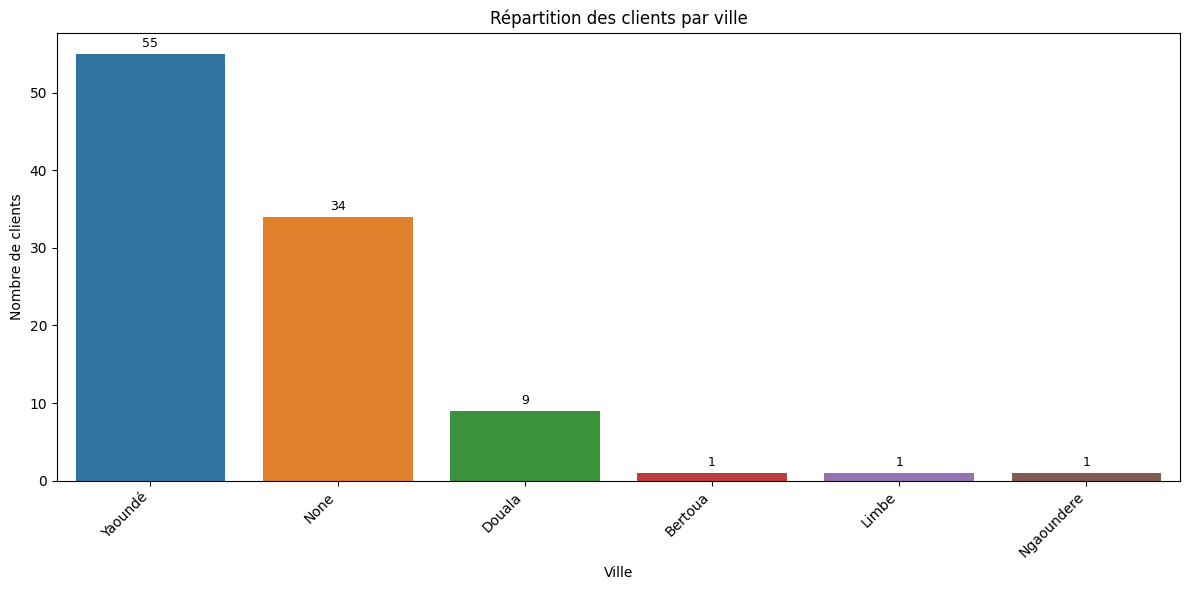

In [19]:
# 3.6 Appliquer, exporter, visualiser
df_clients = construire_base_clients(df_extrait)
df_clients.to_csv(PROCESSED_DIR / "clients(v1).csv", index=False)
afficher_repartition_clients_par_ville(df_clients)

In [20]:
# Charger le fichier clients.csv
df_clients = pd.read_csv(PROCESSED_DIR / "clients(v1).csv")

# Afficher les premières lignes
print("Aperçu du début du fichier :")
display(df_clients.head())

Aperçu du début du fichier :


,client_id,nom,numero,nb_proformas,ville,alias
0,CLT0080,Abeng Joséphine,697252757,5,Yaoundé,[]
1,CLT0030,Akete Oyono Gladys,677428218,7,Yaoundé,"['Akete Oyono Gladys', 'Akete Oyono Gladis']"
2,CLT0089,Akono Martin,698989615,1,Yaoundé,[]
3,CLT0087,Amandjou Carine,697786306,2,Yaoundé,"['Carine Amandjou', 'Amandjou Carine']"
4,CLT0033,Ambassa,677877688,3,Yaoundé,[]


In [21]:
# Afficher les dernières lignes
print("\nAperçu de la fin du fichier :")
display(df_clients.tail())


Aperçu de la fin du fichier :


,client_id,nom,numero,nb_proformas,ville,alias
96,CLT0007,Thomas Nkoum,652441138,8,Yaoundé,"['Thomas Nkoum', 'Nkoum Lewis']"
97,CLT0001,Yannick Eda,620002652,2,Yaoundé,[]
98,CLT0041,Yannick Ngalamo,679487231,9,NaN,[]
99,CLT0082,Yves Atangana,697349074,3,Yaoundé,[]
100,CLT0020,Zacharie Hotamie,674867186,8,Ngaoundere,"['Zacharie Hotamie', 'Hotami Zacharie']"


## **4. Analyse des ventes de 2023**

Dans cette étape, on charge et consolide les ventes 2023 à partir de plusieurs fichiers CSV, en uniformisant les noms, numéros et adresses pour produire un ventes_2023.csv propre et exploitable pour les analyses.

### **4.1- Fusion des ventes de 2023**

In [22]:
VENTES_2023_DIR = BASE_DIR / "data" / "raw" / "Ventes_2023"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

# Colonnes standardisées pour la fusion finale
COLUMNS = ["nom", "telephone", "commande", "montant", "adresse", "frais_livraison", "bon_fidelite", "ville"]

print("🔥 DÉMARRAGE - CONSOLIDATION VENTES 2023")
print(f"📂 Répertoire source: {VENTES_2023_DIR}")
print(f"📂 Répertoire sortie: {PROCESSED_DIR}")


🔥 DÉMARRAGE - CONSOLIDATION VENTES 2023
📂 Répertoire source: ../data/raw/Ventes_2023
📂 Répertoire sortie: ../data/processed


In [23]:
# Vérifier que le répertoire source existe
if not VENTES_2023_DIR.exists():
    print(f"❌ ERREUR: Le répertoire {VENTES_2023_DIR} n'existe pas!")

# Fonctions utilitaires de nettoyage
def clean_name(nom):
    if pd.isna(nom) or str(nom).strip().lower() in ["", "nan", "/", "--"]:
        return "(None)"
    nom = re.sub(r"(mme\.?|mr\.?|m\.?|mlle\.?)", "", str(nom), flags=re.IGNORECASE)
    nom = re.sub(r"[^\w\s\-àâäéèêëîïôöùûüÿñç]", "", nom).strip().title()
    return nom if nom else "(None)"

def clean_phone(phone):
    if pd.isna(phone) or str(phone).strip().lower() in ["", "nan", "/", "--"]:
        return "(None)"
    return str(phone).strip()

def clean_money(val):
    if pd.isna(val):
        return "0"
    val_str = re.sub(r"[^\d]", "", str(val))
    return val_str if val_str else "0"

def clean_text_field(val):
    if pd.isna(val) or str(val).strip().lower() in ["", "nan", "/", "--"]:
        return "(None)"
    return str(val).strip()

def detect_ville_from_address(adresse_str, source_file):
    adresse_lower = str(adresse_str).strip().lower()
    source_lower = source_file.lower().replace('.csv', '')
    if any(ville in adresse_lower for ville in ["douala", "nanga", "tonga"]):
        for ville in ["douala", "nanga", "tonga"]:
            if ville in adresse_lower:
                return ville.title(), "(None)"
    if source_lower == "boutique":
        return "Yaoundé", "Efoulan"
    elif source_lower in ["associations", "partenaires", "livre seconde main"]:
        return "Yaoundé", adresse_str
    return "Yaoundé", adresse_str

In [24]:
# Liste pour stocker tous les DataFrames
all_ventes = []

csv_files = list(VENTES_2023_DIR.glob("*.csv"))

if not csv_files:
    print(f"❌ ERREUR: Aucun fichier CSV trouvé dans {VENTES_2023_DIR}")

print(f"📋 Fichiers trouvés: {[f.name for f in csv_files]}\n")

📋 Fichiers trouvés: ['Partenaires.csv', 'livre seconde main.csv', 'Associations.csv', 'Boutique.csv', 'BOPACE SARL.csv', 'Yaoundé.csv']



In [25]:
for path in csv_files:
    try:
        print(f"Traitement: {path.name}")
        df = pd.read_csv(path, sep=None, engine="python", encoding='utf-8')
        if df.empty:
            print(f"⚠️  Fichier vide: {path.name}")
            continue

        print(f"   Lignes lues: {len(df)}")
        print(f"   Colonnes: {list(df.columns)}")

        df.columns = [col.strip().lower() for col in df.columns]
        df_std = pd.DataFrame()

        if "nom" in df.columns:
            df_std["nom"] = df["nom"].apply(clean_name)
        else:
            df_std["nom"] = "(None)"

        if "telephone" in df.columns:
            df_std["telephone"] = df["telephone"].apply(clean_phone)
        else:
            df_std["telephone"] = "(None)"

        if "commande/classe" in df.columns:
            df_std["commande"] = df["commande/classe"].apply(clean_text_field)
        else:
            df_std["commande"] = "(None)"

        if "somme percue" in df.columns:
            df_std["montant"] = df["somme percue"].apply(clean_money)
        else:
            df_std["montant"] = "0"

        if "lieu de livraison" in df.columns:
            adresse_brute = df["lieu de livraison"].apply(clean_text_field)
        else:
            adresse_brute = "(None)"

        if "frais de livraison" in df.columns:
            df_std["frais_livraison"] = df["frais de livraison"].apply(clean_money)
        else:
            df_std["frais_livraison"] = "0"

        if "bon de fidelite" in df.columns:
            df_std["bon_fidelite"] = df["bon de fidelite"].apply(clean_money)
        else:
            df_std["bon_fidelite"] = "0"

        ville_adresse = adresse_brute.apply(lambda x: detect_ville_from_address(x, path.name))
        df_std["ville"] = ville_adresse.apply(lambda x: x[0])
        df_std["adresse"] = ville_adresse.apply(lambda x: x[1])
        df_std["ville"] = df_std["ville"].replace("(None)", "Yaoundé")

        for col in COLUMNS:
            if col not in df_std.columns:
                df_std[col] = "(None)" if col not in ["montant", "frais_livraison", "bon_fidelite"] else "0"

        df_final = df_std[COLUMNS].copy()
        all_ventes.append(df_final)
        print(f"   ✅ Succès: {len(df_final)} lignes standardisées")
        villes_detectees = df_final["ville"].value_counts()
        print(f"   Villes détectées: {dict(villes_detectees)}\n")

    except Exception as e:
        print(f"   ❌ Erreur avec {path.name}: {str(e)}")

print(f"- FUSION FINALE")
print(f"- Fichiers traités avec succès: {len(all_ventes)}\n")

Traitement: Partenaires.csv
   Lignes lues: 5
   Colonnes: ['N°', 'NOM', 'TELEPHONE', 'COMMANDE/CLASSE', 'SOMME PERCUE', 'LIEU DE LIVRAISON', 'FRAIS DE LIVRAISON']
   ✅ Succès: 5 lignes standardisées
   Villes détectées: {'Douala': np.int64(4), 'Yaoundé': np.int64(1)}

Traitement: livre seconde main.csv
   Lignes lues: 10
   Colonnes: ['NOM', 'TELEPHONE', 'COMMANDE/CLASSE', 'SOMME PERCUE', 'LIEU DE LIVRAISON', 'FRAIS DE LIVRAISON']
   ✅ Succès: 10 lignes standardisées
   Villes détectées: {'Yaoundé': np.int64(10)}

Traitement: Associations.csv
   Lignes lues: 2
   Colonnes: ['NOM', 'TELEPHONE', 'COMMANDE/CLASSE', 'SOMME PERCUE', 'LIEU DE LIVRAISON', 'FRAIS DE LIVRAISON']
   ✅ Succès: 2 lignes standardisées
   Villes détectées: {'Nanga': np.int64(1), 'Tonga': np.int64(1)}

Traitement: Boutique.csv
   Lignes lues: 75
   Colonnes: ['NOM', 'TELEPHONE', 'COMMANDE/CLASSE', 'SOMME PERCUE', 'LIEU DE LIVRAISON', 'FRAIS DE LIVRAISON']
   ✅ Succès: 75 lignes standardisées
   Villes détectées: {'Y

In [26]:
ventes_2023 = pd.concat(all_ventes, ignore_index=True)
ventes_2023["ville"] = ventes_2023["ville"].replace("(None)", "Yaoundé")

print(f"- RÉSUMÉ FINAL:")
print(f"   • Total lignes: {len(ventes_2023)}")
print(f"   • Colonnes: {list(ventes_2023.columns)}")
print(f"   • Villes uniques: {sorted(ventes_2023['ville'].unique())}")

- RÉSUMÉ FINAL:
   • Total lignes: 307
   • Colonnes: ['nom', 'telephone', 'commande', 'montant', 'adresse', 'frais_livraison', 'bon_fidelite', 'ville']
   • Villes uniques: ['Douala', 'Nanga', 'Tonga', 'Yaoundé']


In [27]:
none_count = (ventes_2023["ville"] == "(None)").sum()
print(f"   • Villes avec valeur '(None)': {none_count} ")

   • Villes avec valeur '(None)': 0 


In [28]:
print(f"\n- RÉPARTITION PAR VILLE:")
ville_counts = ventes_2023["ville"].value_counts()
for ville, count in ville_counts.items():
    print(f"   • {ville}: {count} ventes")


- RÉPARTITION PAR VILLE:
   • Yaoundé: 301 ventes
   • Douala: 4 ventes
   • Nanga: 1 ventes
   • Tonga: 1 ventes


In [29]:
print(ventes_2023.head().to_string(index=False)) # en tête du dataframe

                nom           telephone              commande montant adresse frais_livraison bon_fidelite   ville
Socarrea Ettraba Sa 679538330/675270413                (None)  547330  (None)               0            0  Douala
             Adforc           656929292                (None)  394250  (None)               0            0  Douala
             Adforc           656929292                (None)  576000  (None)               0            0  Douala
              Upoca              (None) Livres et fournitures 1059852  (None)               0            0  Douala
          The Seeds              (None)      Livres africains  293000 Yaoundé               0            0 Yaoundé


In [30]:
print(ventes_2023.tail().to_string(index=False))  # pied du dataframe

           nom telephone   commande montant          adresse frais_livraison bon_fidelite   ville
        Ndongo    (None) Uppersixth    5000          Efoualn               0            0 Yaoundé
 Olive Issekin 674281111        CM1    4500 Montée des sœurs               0            0 Yaoundé
     Yvan Ngue 654274610     Form 4    4000          Efoulan               0            0 Yaoundé
Ebanda Vincent 656141983         CP    6500          Efoulan               0            0 Yaoundé
          Babi 694433700     Form 3   20000          Efoulan               0            0 Yaoundé


In [31]:
output_path = PROCESSED_DIR / "ventes_2023.csv"
ventes_2023.to_csv(output_path, index=False, encoding='utf-8')
print(f"\n✅ SUCCÈS: Fichier sauvegardé → {output_path}")


✅ SUCCÈS: Fichier sauvegardé → ../data/processed/ventes_2023.csv


In [32]:
print(f"\nVÉRIFICATION DU FICHIER FINAL:")
df_check = pd.read_csv(output_path)
print(f"   • Lignes dans le fichier: {len(df_check)}")
print(f"   • Villes présentes: {sorted(df_check['ville'].unique())}")

none_final = (df_check["ville"] == "(None)").sum()
print(f"   • Villes avec '(None)' dans le fichier final: {none_final}")


VÉRIFICATION DU FICHIER FINAL:
   • Lignes dans le fichier: 307
   • Villes présentes: ['Douala', 'Nanga', 'Tonga', 'Yaoundé']
   • Villes avec '(None)' dans le fichier final: 0


### **4.2 - Construction de la base clients (clients_2023.csv)**

In [33]:
VENTES_2023_PATH = PROCESSED_DIR / "ventes_2023.csv"
CLIENTS_2023_PATH = PROCESSED_DIR / "clients_2023.csv"

print("Chargement du fichier ventes_2023.csv...")
ventes_df = pd.read_csv(VENTES_2023_PATH)
print(f"✅ {len(ventes_df)} lignes chargées")

Chargement du fichier ventes_2023.csv...
✅ 307 lignes chargées


In [34]:
# Extraire les téléphones secondaires (séparateurs / ou -)
def split_telephones(telephone):
    if pd.isna(telephone):
        return telephone, None
    parts = re.split(r"[\-/]", str(telephone))
    parts = [p.strip() for p in parts if p.strip() and p.strip().lower() != "none"]
    if len(parts) == 1:
        return parts[0], None
    return parts[0], parts[1]
ventes_df[["telephone_principal", "telephone_secondaire"]] = ventes_df.apply(
    lambda row: pd.Series(split_telephones(row["telephone"])), axis=1
)

In [35]:
# Filtrer les lignes avec un numéro valide
ventes_df = ventes_df[ventes_df["telephone_principal"].notna() & (ventes_df["telephone_principal"] != "(None)")]

In [36]:
# Grouper les clients par téléphone principal
print("👥 Construction de la base clients...")
clients_df = ventes_df.groupby("telephone_principal").agg({
    "nom": lambda x: sorted(set(x)),
    "telephone_secondaire": lambda x: next((v for v in x if pd.notna(v)), None),
    "commande": lambda x: ", ".join(sorted(set(x.dropna()))),
    "adresse": lambda x: next((v for v in x if pd.notna(v) and v != "(None)"), "(None)"),
    "ville": lambda x: next((v for v in x if pd.notna(v) and v != "(None)"), "(None)"),
    "telephone_principal": "count"
}).rename(columns={
    "nom": "alias",
    "telephone_secondaire": "telephone_secondaire",
    "commande": "commande",
    "adresse": "adresse",
    "ville": "ville",
    "telephone_principal": "nb_commandes"
}).reset_index().rename(columns={"telephone_principal": "telephone"})

👥 Construction de la base clients...


In [37]:
# Créer la colonne nom principal (premier alias trié hors nom principal)
clients_df["nom"] = clients_df["alias"].apply(lambda x: x[0] if isinstance(x, list) and x else "")
clients_df["alias"] = clients_df.apply(lambda row: ", ".join([a for a in row["alias"] if a != row["nom"]]), axis=1)

# Réorganiser et trier les colonnes avec alias inclus
clients_df = clients_df[["nom", "alias", "telephone", "telephone_secondaire", "commande", "adresse", "ville", "nb_commandes"]]
clients_df = clients_df.sort_values("nom")

In [38]:
print(f"{len(clients_df)} clients extraits")
print("ÉCHANTILLON :")
print(clients_df.head().to_string(index=False))

180 clients extraits
ÉCHANTILLON :
       nom alias telephone telephone_secondaire         commande         adresse   ville  nb_commandes
    Abassa       698068565                 None     6ème, Form 2 Carrefour Warda Yaoundé             1
  Abessolo       652338356                 None Maternelle 1 & 2        Mimboman Yaoundé             2
    Abongo       653661379                 None          Class 4         Efoulan Yaoundé             1
Addja Inna       699970603                 None              CEI      Biyem-assi Yaoundé             1
    Adforc       656929292                 None           (None)          (None)  Douala             2


In [39]:
# Sauvegarde du fichier
clients_df.to_csv(CLIENTS_2023_PATH, index=False, encoding='utf-8')
print(f"📁 Fichier sauvegardé → {CLIENTS_2023_PATH}")

📁 Fichier sauvegardé → ../data/processed/clients_2023.csv


### **4.3 - Analyse des performances commerciales 2023**

Le chiffre d’affaires est la somme des ventes réalisées par une entreprise sur une période donnée. Il s’agit du montant total encaissé ou facturé, hors remises et hors taxes, pour les biens ou services vendus.

In [40]:
# Nettoyage des colonnes nécessaires au calcul
ventes_df["montant"] = pd.to_numeric(ventes_df["montant"], errors="coerce").fillna(0).astype(int)
ventes_df["frais_livraison"] = pd.to_numeric(ventes_df["frais_livraison"], errors="coerce").fillna(0).astype(int)

# Calcul du chiffre d'affaires total
ventes_df["chiffre_affaire"] = ventes_df["montant"] + ventes_df["frais_livraison"]
ca_total = ventes_df["chiffre_affaire"].sum()
print(f"\n💰 Chiffre d'affaires total 2023 : {ca_total:,.0f} FCFA")


💰 Chiffre d'affaires total 2023 : 16,206,302 FCFA


/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/3511896456.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_clients.index, y=top_clients.values, palette="viridis")


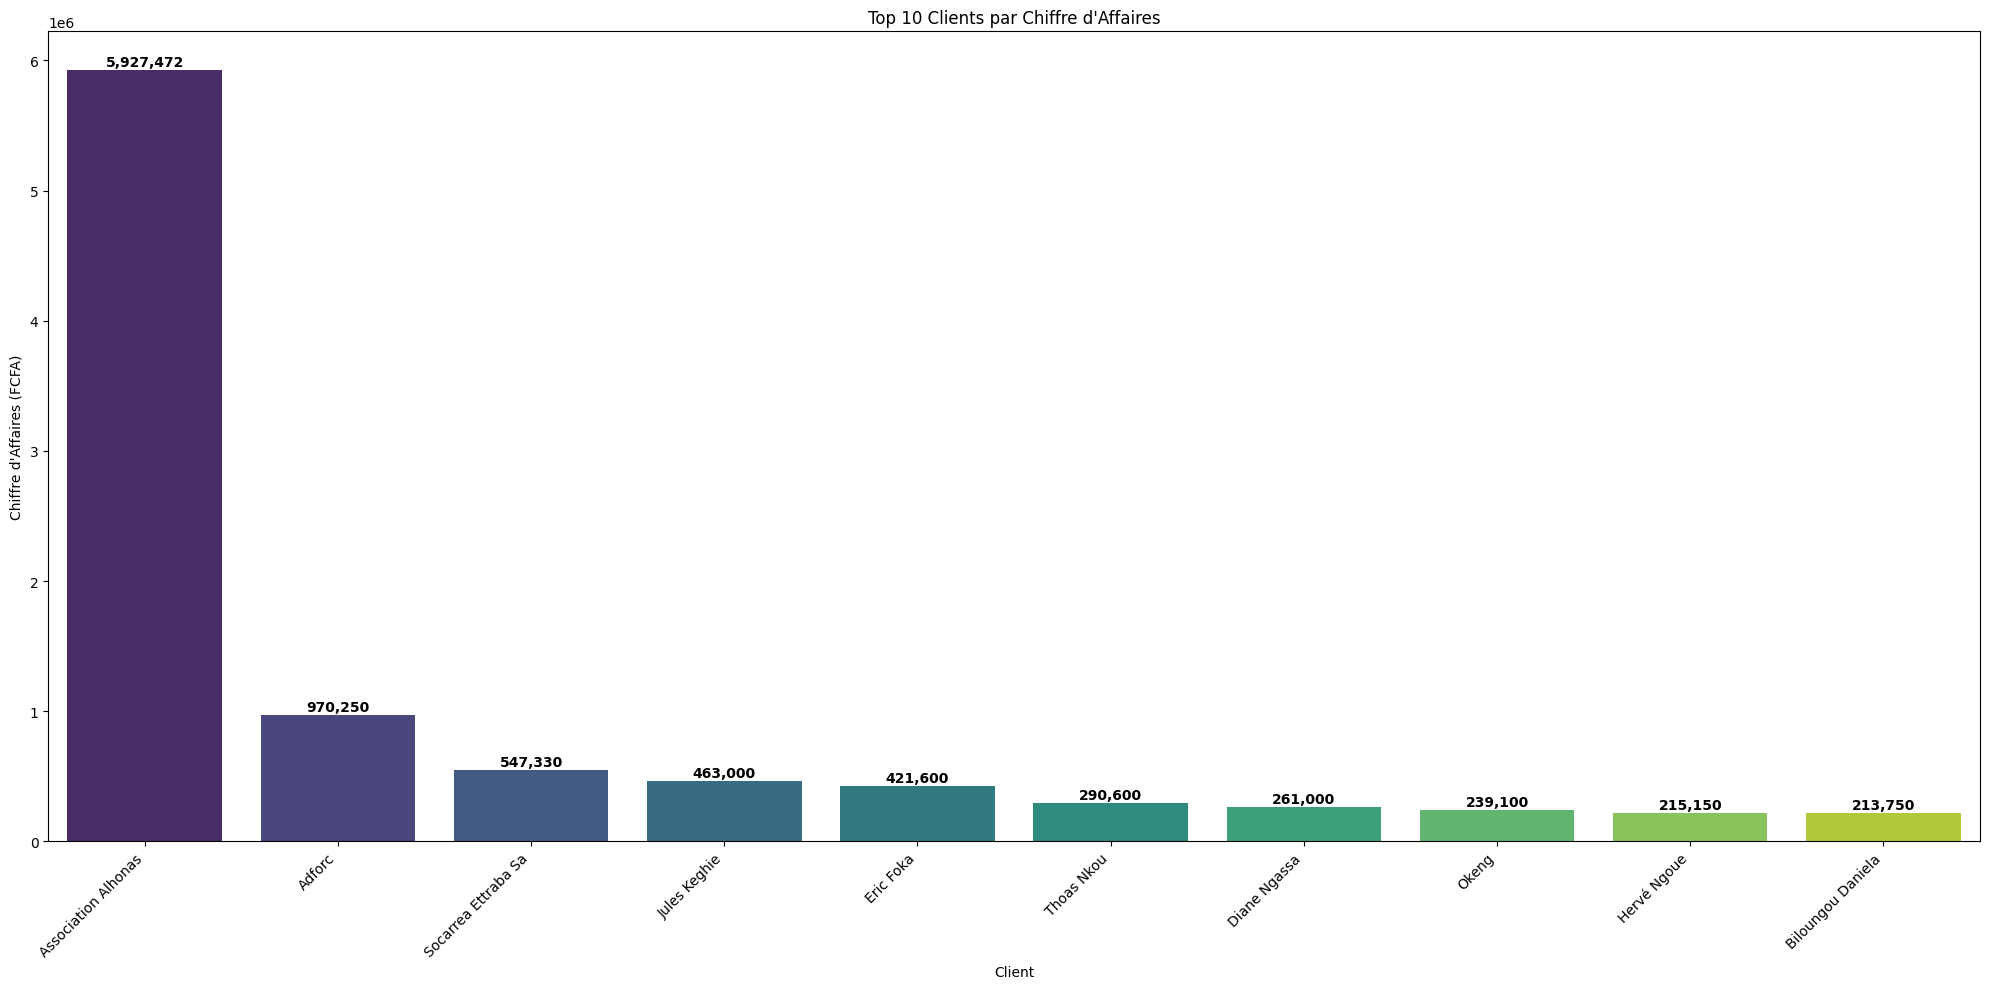

In [41]:
# Graphique 1 - Top 5 clients (nom sur l’axe x)
top_clients = ventes_df.groupby("nom")["chiffre_affaire"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=top_clients.index, y=top_clients.values, palette="viridis")
plt.title("Top 10 Clients par Chiffre d'Affaires")
plt.xlabel("Client")
plt.ylabel("Chiffre d'Affaires (FCFA)")

# Afficher les valeurs au-dessus des barres
for i, value in enumerate(top_clients.values):
    ax.text(i, value + 10000, f"{value:,.0f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/35618397.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=ca_par_ville.index, y=ca_par_ville.values, palette="colorblind")


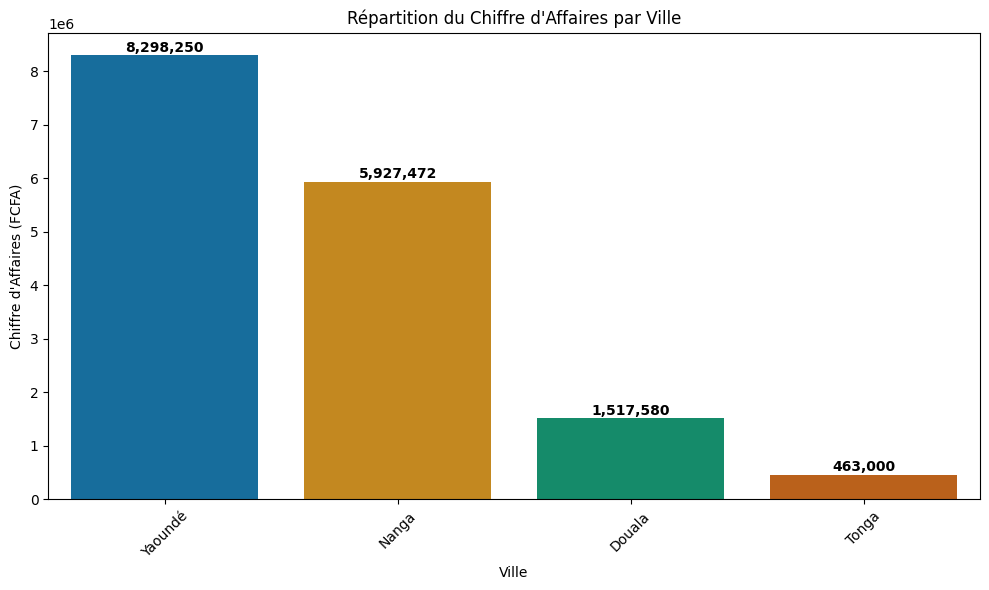

In [42]:
# Graphique 2 - Répartition des ventes par ville
ca_par_ville = ventes_df.groupby("ville")["chiffre_affaire"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x=ca_par_ville.index, y=ca_par_ville.values, palette="colorblind")
plt.title("Répartition du Chiffre d'Affaires par Ville")
plt.xlabel("Ville")
plt.ylabel("Chiffre d'Affaires (FCFA)")

# Valeurs au-dessus des barres
for i, value in enumerate(ca_par_ville.values):
    ax2.text(i, value + 10000, f"{value:,.0f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **5. Analyse des ventes de 2024**

Dans cette étape, on charge et consolide les ventes 2024 à partir de plusieurs fichiers CSV, en uniformisant les noms, numéros et adresses pour produire un ventes_2024.csv propre et exploitable pour les analyses.

### **5.1- Fusion des ventes de 2024**

In [43]:
VENTES_2024_DIR = BASE_DIR / "data" / "raw" / "Ventes_2024"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

# Colonnes standardisées pour la fusion finale
COLUMNS = ["nom", "telephone", "commande", "montant", "adresse", "frais_livraison", "bon_fidelite", "ville"]

print("🔥 DÉMARRAGE - CONSOLIDATION VENTES 2024 (VERSION CORRIGÉE)")
print(f"📂 Répertoire source: {VENTES_2024_DIR}")
print(f"📂 Répertoire sortie: {PROCESSED_DIR}")

# Vérifier que le répertoire source existe
if not VENTES_2024_DIR.exists():
    print(f"❌ ERREUR: Le répertoire {VENTES_2024_DIR} n'existe pas!")
    exit(1)

🔥 DÉMARRAGE - CONSOLIDATION VENTES 2024 (VERSION CORRIGÉE)
📂 Répertoire source: ../data/raw/Ventes_2024
📂 Répertoire sortie: ../data/processed


In [44]:
# Mapping des filiales vers leurs villes
FILIALES_VILLES = {
    "adforce": "Yaoundé", 
    "association alhonas": "Yaoundé",
    "association famille keghie": "Yaoundé", 
    "bopace sarl": "Yaoundé",
    "mutuelle feicom": "Yaoundé",
    "petit ecolier": "Yaoundé",
    "soneco sarl": "Yaoundé",
    "soccarema": "Douala",
    "prestataire eneo douala": "Douala",
    "yaoundé": "Yaoundé",
    "douala": "Douala"
}

# Montants réels des filiales (extraits des fichiers)
MONTANTS_FILIALES = {
    "adforce": "1269975",  # ADFORCE : ASSOCIATION DES FEMMES D'ORANGE CAMEROUN
    "association alhonas": "3602310",
    "association famille keghie": "419100", 
    "bopace sarl": "435340",
    "mutuelle feicom": "4797450",
    "petit ecolier": "2498850",
    "soneco sarl": "640000",
    "soccarema": "262105",
    "prestataire eneo douala": "3320950"
}

In [45]:
# Fonctions utilitaires de nettoyage
def clean_name(nom):
    """Nettoie et standardise les noms de clients"""
    if pd.isna(nom) or str(nom).strip().lower() in ["", "nan", "/", "--"]:
        return "(None)"
    
    # Supprimer les titres civiques
    nom = re.sub(r"(mme\.?|mr\.?|m\.?|mlle\.?)", "", str(nom), flags=re.IGNORECASE)
    
    # Garder seulement les caractères alphanumériques, espaces, tirets et accents français
    nom = re.sub(r"[^\w\s\-àâäéèêëîïôöùûüÿñç]", "", nom).strip().title()
    
    return nom if nom else "(None)"

def clean_phone(phone):
    """Nettoie les numéros de téléphone"""
    if pd.isna(phone) or str(phone).strip().lower() in ["", "nan", "/", "--"]:
        return "(None)"
    return str(phone).strip()

def extract_amount(val):
    """Extrait le montant numérique d'une chaîne (ex: '1 269 975 FCFA' -> '1269975')"""
    if pd.isna(val):
        return "0"
    
    # Convertir en string et extraire tous les chiffres
    val_str = str(val)
    
    # Supprimer tout ce qui n'est pas un chiffre
    numbers_only = re.sub(r'[^\d]', '', val_str)
    
    return numbers_only if numbers_only else "0"

def clean_text_field(val):
    """Nettoie les champs texte génériques"""
    if pd.isna(val) or str(val).strip().lower() in ["", "nan", "/", "--"]:
        return "(None)"
    return str(val).strip()

def detect_ville_from_source(source_file):
    """Détermine la ville en fonction du nom du fichier source"""
    source_clean = source_file.lower().replace('.csv', '')
    
    # Recherche directe dans le mapping
    for key, ville in FILIALES_VILLES.items():
        if key in source_clean:
            return ville
    
    # Par défaut Yaoundé si non trouvé
    return "Yaoundé"

def get_filiale_key(filename):
    """Extrait la clé de filiale du nom de fichier"""
    filename_clean = filename.lower().replace('.csv', '')
    
    # Recherche de correspondance dans les clés
    for key in MONTANTS_FILIALES.keys():
        if key in filename_clean:
            return key
    
    return None

def process_individual_file(path):
    """Traite un fichier CSV individuel"""
    print(f"📄 Traitement: {path.name}")
    
    try:
        # Lecture du fichier avec différents séparateurs possibles
        df = pd.read_csv(path, sep=None, engine="python", encoding='utf-8')
        
        if df.empty:
            print(f"⚠️  Fichier vide: {path.name}")
            return None
            
        print(f"   📊 Lignes lues: {len(df)}")
        print(f"   📋 Colonnes: {list(df.columns)}")
        
        # Standardisation des noms de colonnes
        df.columns = [col.strip().lower() for col in df.columns]
        
        # Détection de la ville basée sur le nom du fichier
        ville_source = detect_ville_from_source(path.name)
        print(f"   🏙️  Ville détectée: {ville_source}")
        
        # Traitement spécifique selon le type de fichier
        if any(col in df.columns for col in ["client", "nom"]):
            # Fichiers avec données clients détaillées (Yaoundé.csv, Douala.csv)
            return process_client_file(df, ville_source, path.name)
        else:
            # Fichiers de filiales avec montants globaux
            return process_filiale_file(df, ville_source, path.name)
            
    except Exception as e:
        print(f"   ❌ Erreur avec {path.name}: {str(e)}")
        return None

def process_client_file(df, ville, filename):
    """Traite les fichiers avec données clients détaillées"""
    df_std = pd.DataFrame()
    
    # Mapping des colonnes pour le nom
    if "client" in df.columns:
        df_std["nom"] = df["client"].apply(clean_name)
    elif "nom" in df.columns:
        df_std["nom"] = df["nom"].apply(clean_name)
    else:
        df_std["nom"] = "(None)"
    
    # Téléphone
    if "telephone" in df.columns:
        df_std["telephone"] = df["telephone"].apply(clean_phone)
    else:
        df_std["telephone"] = "(None)"
    
    # Commande/Classe
    commande_cols = ["commande/ classe", "commande/classe", "classe (concernée)", "commande"]
    commande_col = None
    for col in commande_cols:
        if col in df.columns:
            commande_col = col
            break
    
    if commande_col:
        df_std["commande"] = df[commande_col].apply(clean_text_field)
    else:
        df_std["commande"] = "(None)"
    
    # Montant - recherche dans plusieurs colonnes possibles
    montant_cols = ["somme percue", "paiement recu", "montant percu", "montant", "somme perçue", "paiement reçu", "montant perçu"]
    montant_col = None
    for col in montant_cols:
        if col in df.columns:
            montant_col = col
            break
    
    if montant_col:
        df_std["montant"] = df[montant_col].apply(extract_amount)
    else:
        df_std["montant"] = "0"
    
    # Adresse
    adresse_cols = ["lieu de livraison", "quartier (de résidence)", "adresse"]
    adresse_col = None
    for col in adresse_cols:
        if col in df.columns:
            adresse_col = col
            break
    
    if adresse_col:
        df_std["adresse"] = df[adresse_col].apply(clean_text_field)
    else:
        df_std["adresse"] = "(None)"
    
    # Frais de livraison
    if "frais de livraison" in df.columns:
        df_std["frais_livraison"] = df["frais de livraison"].apply(extract_amount)
    else:
        df_std["frais_livraison"] = "0"
    
    # Bon de fidélité
    bon_cols = ["bon de felite", "bon de fidelite", "bon de félité"]
    bon_col = None
    for col in bon_cols:
        if col in df.columns:
            bon_col = col
            break
    
    if bon_col:
        df_std["bon_fidelite"] = df[bon_col].apply(extract_amount)
    else:
        df_std["bon_fidelite"] = "0"
    
    # Ville
    df_std["ville"] = ville
    
    return df_std[COLUMNS].copy()

def process_filiale_file(df, ville, filename):
    """Traite les fichiers de filiales avec montants globaux"""
    # Extraire le nom de la filiale du nom de fichier
    nom_filiale = filename.replace('.csv', '').upper()
    
    # Obtenir la clé de filiale pour récupérer le montant
    filiale_key = get_filiale_key(filename)
    
    # Utiliser le montant prédéfini ou essayer d'extraire du fichier
    if filiale_key and filiale_key in MONTANTS_FILIALES:
        montant_total = MONTANTS_FILIALES[filiale_key]
        print(f"   💰 Montant prédéfini utilisé: {montant_total} FCFA")
    else:
        # Fallback : essayer d'extraire du fichier
        montant_total = "0"
        
        # Recherche du montant dans différentes colonnes possibles
        montant_cols = ["net a payer", "montant percu", "montant perçu", "deja percu", "déjà perçu"]
        
        print(f"   🔍 Recherche de montant dans les colonnes: {list(df.columns)}")
        
        for col in montant_cols:
            if col in df.columns:
                print(f"   📊 Colonne trouvée: {col}")
                # Prendre la première valeur non nulle
                for idx, val in df[col].items():
                    if pd.notna(val) and str(val).strip() not in ["", "/", "nan"]:
                        montant_total = extract_amount(val)
                        print(f"   💰 Montant extrait: {val} -> {montant_total}")
                        break
                if montant_total != "0":
                    break
    
    # Créer une ligne pour cette filiale
    df_std = pd.DataFrame({
        "nom": [nom_filiale],
        "telephone": ["(None)"],
        "commande": ["VENTE FILIALE"],
        "montant": [montant_total],
        "adresse": [f"FILIALE {ville}"],
        "frais_livraison": ["0"],
        "bon_fidelite": ["0"],
        "ville": [ville]
    })
    
    return df_std

In [46]:
# Liste pour stocker tous les DataFrames
all_ventes = []

# Récupération de tous les fichiers CSV
csv_files = list(VENTES_2024_DIR.glob("*.csv"))

if not csv_files:
    print(f"❌ ERREUR: Aucun fichier CSV trouvé dans {VENTES_2024_DIR}")
    exit(1)

print(f"📋 Fichiers trouvés: {len(csv_files)}")
for f in csv_files:
    print(f"   • {f.name}")
print()

📋 Fichiers trouvés: 11
   • ASSOCIATION FAMILLE KEGHIE.csv
   • PETIT ECOLIER.csv
   • ADFORCE : ASSOCIATION DES FEMMES D'ORANGE CAMEROUN.csv
   • ASSOCIATION ALHONAS.csv
   • PRESTATAIRE ENEO DOUALA.csv
   • SONECO SARL.csv
   • SOCCAREMA.csv
   • Douala.csv
   • BOPACE SARL.csv
   • Yaoundé.csv
   • MUTUELLE FEICOM.csv



In [47]:
# Traitement de chaque fichier
for path in csv_files:
    df_processed = process_individual_file(path)
    
    if df_processed is not None:
        all_ventes.append(df_processed)
        print(f"   ✅ Succès: {len(df_processed)} lignes standardisées")
        
        # Affichage des statistiques par ville
        if len(df_processed) > 0:
            villes_detectees = df_processed["ville"].value_counts()
            print(f"   🏙️  Villes: {dict(villes_detectees)}")
            
            # Affichage du montant total pour ce fichier
            montant_fichier = df_processed["montant"].apply(lambda x: int(x) if x.isdigit() else 0).sum()
            print(f"   💰 Montant fichier: {montant_fichier:,} FCFA")
    
    print()


print(f"Fichiers traités avec succès: {len(all_ventes)}")

📄 Traitement: ASSOCIATION FAMILLE KEGHIE.csv
   📊 Lignes lues: 2
   📋 Colonnes: ['NET A PAYER', '419\u202f100']
   🏙️  Ville détectée: Yaoundé
   💰 Montant prédéfini utilisé: 419100 FCFA
   ✅ Succès: 1 lignes standardisées
   🏙️  Villes: {'Yaoundé': np.int64(1)}
   💰 Montant fichier: 419,100 FCFA

📄 Traitement: PETIT ECOLIER.csv
   📊 Lignes lues: 1
   📋 Colonnes: ['NET A PAYER', '2\u202f498\u202f850']
   🏙️  Ville détectée: Yaoundé
   💰 Montant prédéfini utilisé: 2498850 FCFA
   ✅ Succès: 1 lignes standardisées
   🏙️  Villes: {'Yaoundé': np.int64(1)}
   💰 Montant fichier: 2,498,850 FCFA

📄 Traitement: ADFORCE : ASSOCIATION DES FEMMES D'ORANGE CAMEROUN.csv
   📊 Lignes lues: 2
   📋 Colonnes: ['NET A PAYER', '1\u202f269\u202f975']
   🏙️  Ville détectée: Yaoundé
   💰 Montant prédéfini utilisé: 1269975 FCFA
   ✅ Succès: 1 lignes standardisées
   🏙️  Villes: {'Yaoundé': np.int64(1)}
   💰 Montant fichier: 1,269,975 FCFA

📄 Traitement: ASSOCIATION ALHONAS.csv
   📊 Lignes lues: 2
   📋 Colonnes:

In [48]:
if not all_ventes:
    print("❌ ERREUR: Aucun fichier traité avec succès!")
    exit(1)

# Fusion de tous les DataFrames
ventes_2024 = pd.concat(all_ventes, ignore_index=True)

# Nettoyage final
ventes_2024["ville"] = ventes_2024["ville"].replace("(None)", "Yaoundé")


print(f"\nRÉSUMÉ FINAL - VENTES 2024:")
print(f"   • Total lignes: {len(ventes_2024):,}")
print(f"   • Colonnes: {list(ventes_2024.columns)}")
print(f"   • Villes uniques: {sorted(ventes_2024['ville'].unique())}")


RÉSUMÉ FINAL - VENTES 2024:
   • Total lignes: 240
   • Colonnes: ['nom', 'telephone', 'commande', 'montant', 'adresse', 'frais_livraison', 'bon_fidelite', 'ville']
   • Villes uniques: ['Douala', 'Yaoundé']


In [49]:
# Vérification des valeurs manquantes
none_count = (ventes_2024["ville"] == "(None)").sum()
print(f"   • Villes avec valeur '(None)': {none_count}")

print(f"\n    RÉPARTITION PAR VILLE:")
ville_counts = ventes_2024["ville"].value_counts()
for ville, count in ville_counts.items():
    print(f"   • {ville}: {count:,} ventes")

   • Villes avec valeur '(None)': 0

    RÉPARTITION PAR VILLE:
   • Yaoundé: 194 ventes
   • Douala: 46 ventes


In [50]:
# Calcul des montants totaux
print(f"\n  MONTANTS PAR VILLE:")
montants_par_ville = {}
for ville in sorted(ventes_2024["ville"].unique()):
    ville_data = ventes_2024[ventes_2024["ville"] == ville]
    montant_total = ville_data["montant"].apply(lambda x: int(x) if x.isdigit() else 0).sum()
    montants_par_ville[ville] = montant_total
    print(f"   • {ville}: {montant_total:,} FCFA")

# Montant total général
montant_general = ventes_2024["montant"].apply(lambda x: int(x) if x.isdigit() else 0).sum()
print(f"\n  MONTANT TOTAL 2024: {montant_general:,} FCFA")


  MONTANTS PAR VILLE:
   • Douala: 4,866,195 FCFA
   • Yaoundé: 21,001,475 FCFA

  MONTANT TOTAL 2024: 25,867,670 FCFA


In [51]:
# Détail des montants de filiales
print(f"\n  DÉTAIL MONTANTS FILIALES:")
for nom, montant in MONTANTS_FILIALES.items():
    print(f"   • {nom.upper()}: {int(montant):,} FCFA")


  DÉTAIL MONTANTS FILIALES:
   • ADFORCE: 1,269,975 FCFA
   • ASSOCIATION ALHONAS: 3,602,310 FCFA
   • ASSOCIATION FAMILLE KEGHIE: 419,100 FCFA
   • BOPACE SARL: 435,340 FCFA
   • MUTUELLE FEICOM: 4,797,450 FCFA
   • PETIT ECOLIER: 2,498,850 FCFA
   • SONECO SARL: 640,000 FCFA
   • SOCCAREMA: 262,105 FCFA
   • PRESTATAIRE ENEO DOUALA: 3,320,950 FCFA


In [52]:
# Statistiques détaillées
print(f"\n  STATISTIQUES DÉTAILLÉES:")
print(f"   • Nombre de clients uniques: {ventes_2024['nom'].nunique()}")
print(f"   • Nombre de commandes: {len(ventes_2024)}")
if len(ventes_2024) > 0:
    print(f"   • Montant moyen par commande: {montant_general // len(ventes_2024):,} FCFA")


  STATISTIQUES DÉTAILLÉES:
   • Nombre de clients uniques: 181
   • Nombre de commandes: 240
   • Montant moyen par commande: 107,781 FCFA


In [53]:
# Top 10 des clients par montant
print(f"\n TOP 10 CLIENTS PAR MONTANT:")
top_clients = ventes_2024.copy()
top_clients["montant_num"] = top_clients["montant"].apply(lambda x: int(x) if x.isdigit() else 0)
top_clients_grouped = top_clients.groupby("nom")["montant_num"].sum().sort_values(ascending=False).head(10)

for i, (nom, montant) in enumerate(top_clients_grouped.items(), 1):
    print(f"   {i:2d}. {nom}: {montant:,} FCFA")


 TOP 10 CLIENTS PAR MONTANT:
    1. MUTUELLE FEICOM: 4,797,450 FCFA
    2. ASSOCIATION ALHONAS: 3,602,310 FCFA
    3. PRESTATAIRE ENEO DOUALA: 3,320,950 FCFA
    4. PETIT ECOLIER: 2,498,850 FCFA
    5. ADFORCE : ASSOCIATION DES FEMMES D'ORANGE CAMEROUN: 1,269,975 FCFA
    6. SONECO SARL: 640,000 FCFA
    7. BOPACE SARL: 435,340 FCFA
    8. ASSOCIATION FAMILLE KEGHIE: 419,100 FCFA
    9. Ndjock: 359,000 FCFA
   10. Kade: 295,000 FCFA


In [54]:
# Sauvegarde
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
output_path = PROCESSED_DIR / "ventes_2024.csv"
ventes_2024.to_csv(output_path, index=False, encoding='utf-8')
print(f"\nFichier sauvegardé: {output_path}")


Fichier sauvegardé: ../data/processed/ventes_2024.csv


### **5.2 - Construction de la base clients (clients_2024.csv)**

In [55]:
VENTES_2024_PATH = PROCESSED_DIR / "ventes_2024.csv"
CLIENTS_2024_PATH = PROCESSED_DIR / "clients_2024.csv"

print("Chargement du fichier ventes_2024.csv...")
ventes_df = pd.read_csv(VENTES_2024_PATH)
print(f"✅ {len(ventes_df)} lignes chargées")

Chargement du fichier ventes_2024.csv...
✅ 240 lignes chargées


In [56]:
# Extraire les téléphones secondaires (séparateurs / ou -)
def split_telephones(telephone):
    if pd.isna(telephone):
        return telephone, None
    parts = re.split(r"[\-/]", str(telephone))
    parts = [p.strip() for p in parts if p.strip() and p.strip().lower() != "none"]
    if len(parts) == 1:
        return parts[0], None
    return parts[0], parts[1]

ventes_df[["telephone_principal", "telephone_secondaire"]] = ventes_df.apply(
    lambda row: pd.Series(split_telephones(row["telephone"])), axis=1
)

# Filtrer les lignes avec un numéro valide
ventes_df = ventes_df[ventes_df["telephone_principal"].notna() & (ventes_df["telephone_principal"] != "(None)")]

In [57]:
# Grouper les clients par téléphone principal
print("👥 Construction de la base clients 2024...")
clients_df = ventes_df.groupby("telephone_principal").agg({
    "nom": lambda x: sorted(set(x)),
    "telephone_secondaire": lambda x: next((v for v in x if pd.notna(v)), None),
    "commande": lambda x: ", ".join(sorted(set(x.dropna()))),
    "adresse": lambda x: next((v for v in x if pd.notna(v) and v != "(None)"), "(None)"),
    "ville": lambda x: next((v for v in x if pd.notna(v) and v != "(None)"), "(None)"),
    "telephone_principal": "count"
}).rename(columns={
    "nom": "alias",
    "telephone_secondaire": "telephone_secondaire",
    "commande": "commande",
    "adresse": "adresse",
    "ville": "ville",
    "telephone_principal": "nb_commandes"
}).reset_index().rename(columns={"telephone_principal": "telephone"})

👥 Construction de la base clients 2024...


In [58]:
# Créer la colonne nom principal (premier alias trié hors nom principal)
clients_df["nom"] = clients_df["alias"].apply(lambda x: x[0] if isinstance(x, list) and x else "")
clients_df["alias"] = clients_df.apply(lambda row: ", ".join([a for a in row["alias"] if a != row["nom"]]), axis=1)

# Réorganiser et trier les colonnes avec alias inclus
clients_df = clients_df[["nom", "alias", "telephone", "telephone_secondaire", "commande", "adresse", "ville", "nb_commandes"]]
clients_df = clients_df.sort_values("nom")

print(f"{len(clients_df)} clients extraits")
print("ÉCHANTILLON :")
print(clients_df.head().to_string(index=False))

123 clients extraits
ÉCHANTILLON :
           nom        alias telephone telephone_secondaire                         commande adresse   ville  nb_commandes
Aandjou Carine Carine Bibai 697786306                 None                      FOURNITURES  (None) Yaoundé             2
    Abang Arie       Ndongo 658980041                 None              (None), FOURNITURES  (None) Yaoundé             2
   Abena Yvana              697996592                 None CLASS1 / FORM1, FOURNITURES, SIL  (None) Yaoundé             3
           Ada              695765640                 None                          CLASS 1  (None) Yaoundé             1
  Aella Design              696385893                 None                               5e  (None) Yaoundé             1


In [59]:
# Sauvegarde du fichier
clients_df.to_csv(CLIENTS_2024_PATH, index=False, encoding='utf-8')
print(f"📁 Fichier sauvegardé → {CLIENTS_2024_PATH}")

📁 Fichier sauvegardé → ../data/processed/clients_2024.csv


### **5.3 - Analyse des performances commerciales 2024**

In [60]:
# 1. Chiffre d’affaires par ville
ca_par_ville = ventes_2024.copy()
ca_par_ville["montant"] = ca_par_ville["montant"].apply(lambda x: int(x) if str(x).isdigit() else 0)
ca_par_ville["frais_livraison"] = ca_par_ville["frais_livraison"].apply(lambda x: int(x) if str(x).isdigit() else 0)
ca_par_ville["chiffre_affaire"] = ca_par_ville["montant"] + ca_par_ville["frais_livraison"]

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/3875601928.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=ca_by_ville.index, y=ca_by_ville.values, palette="viridis")


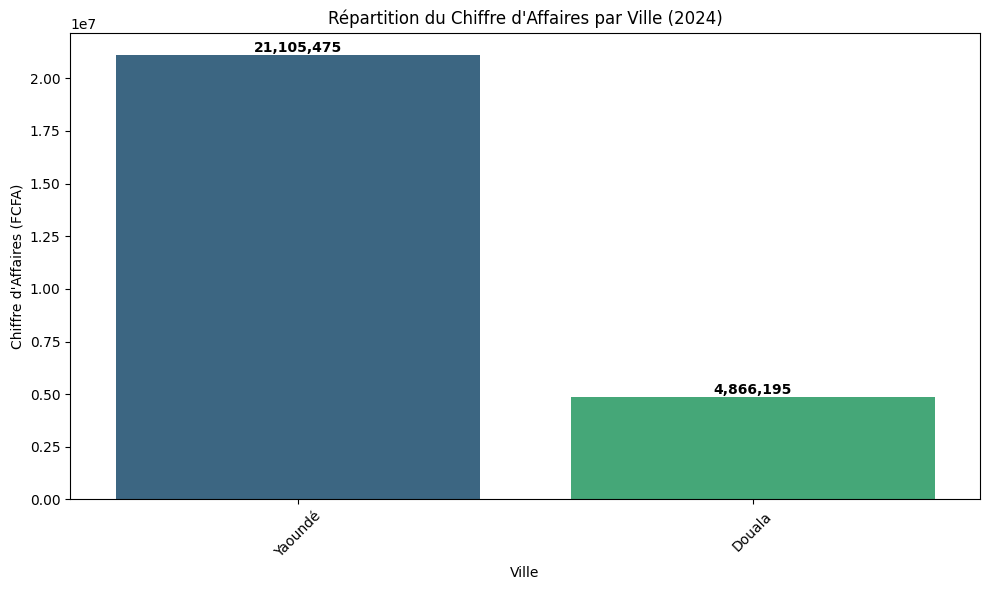

In [61]:
# Graphique 1 - Répartition du chiffre d'affaires par ville
ca_by_ville = ca_par_ville.groupby("ville")["chiffre_affaire"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x=ca_by_ville.index, y=ca_by_ville.values, palette="viridis")
plt.title("Répartition du Chiffre d'Affaires par Ville (2024)")
plt.xlabel("Ville")
plt.ylabel("Chiffre d'Affaires (FCFA)")

for i, value in enumerate(ca_by_ville.values):
    ax1.text(i, value + 5000, f"{value:,.0f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/3001518387.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=top_clients.index, y=top_clients.values, palette="viridis")


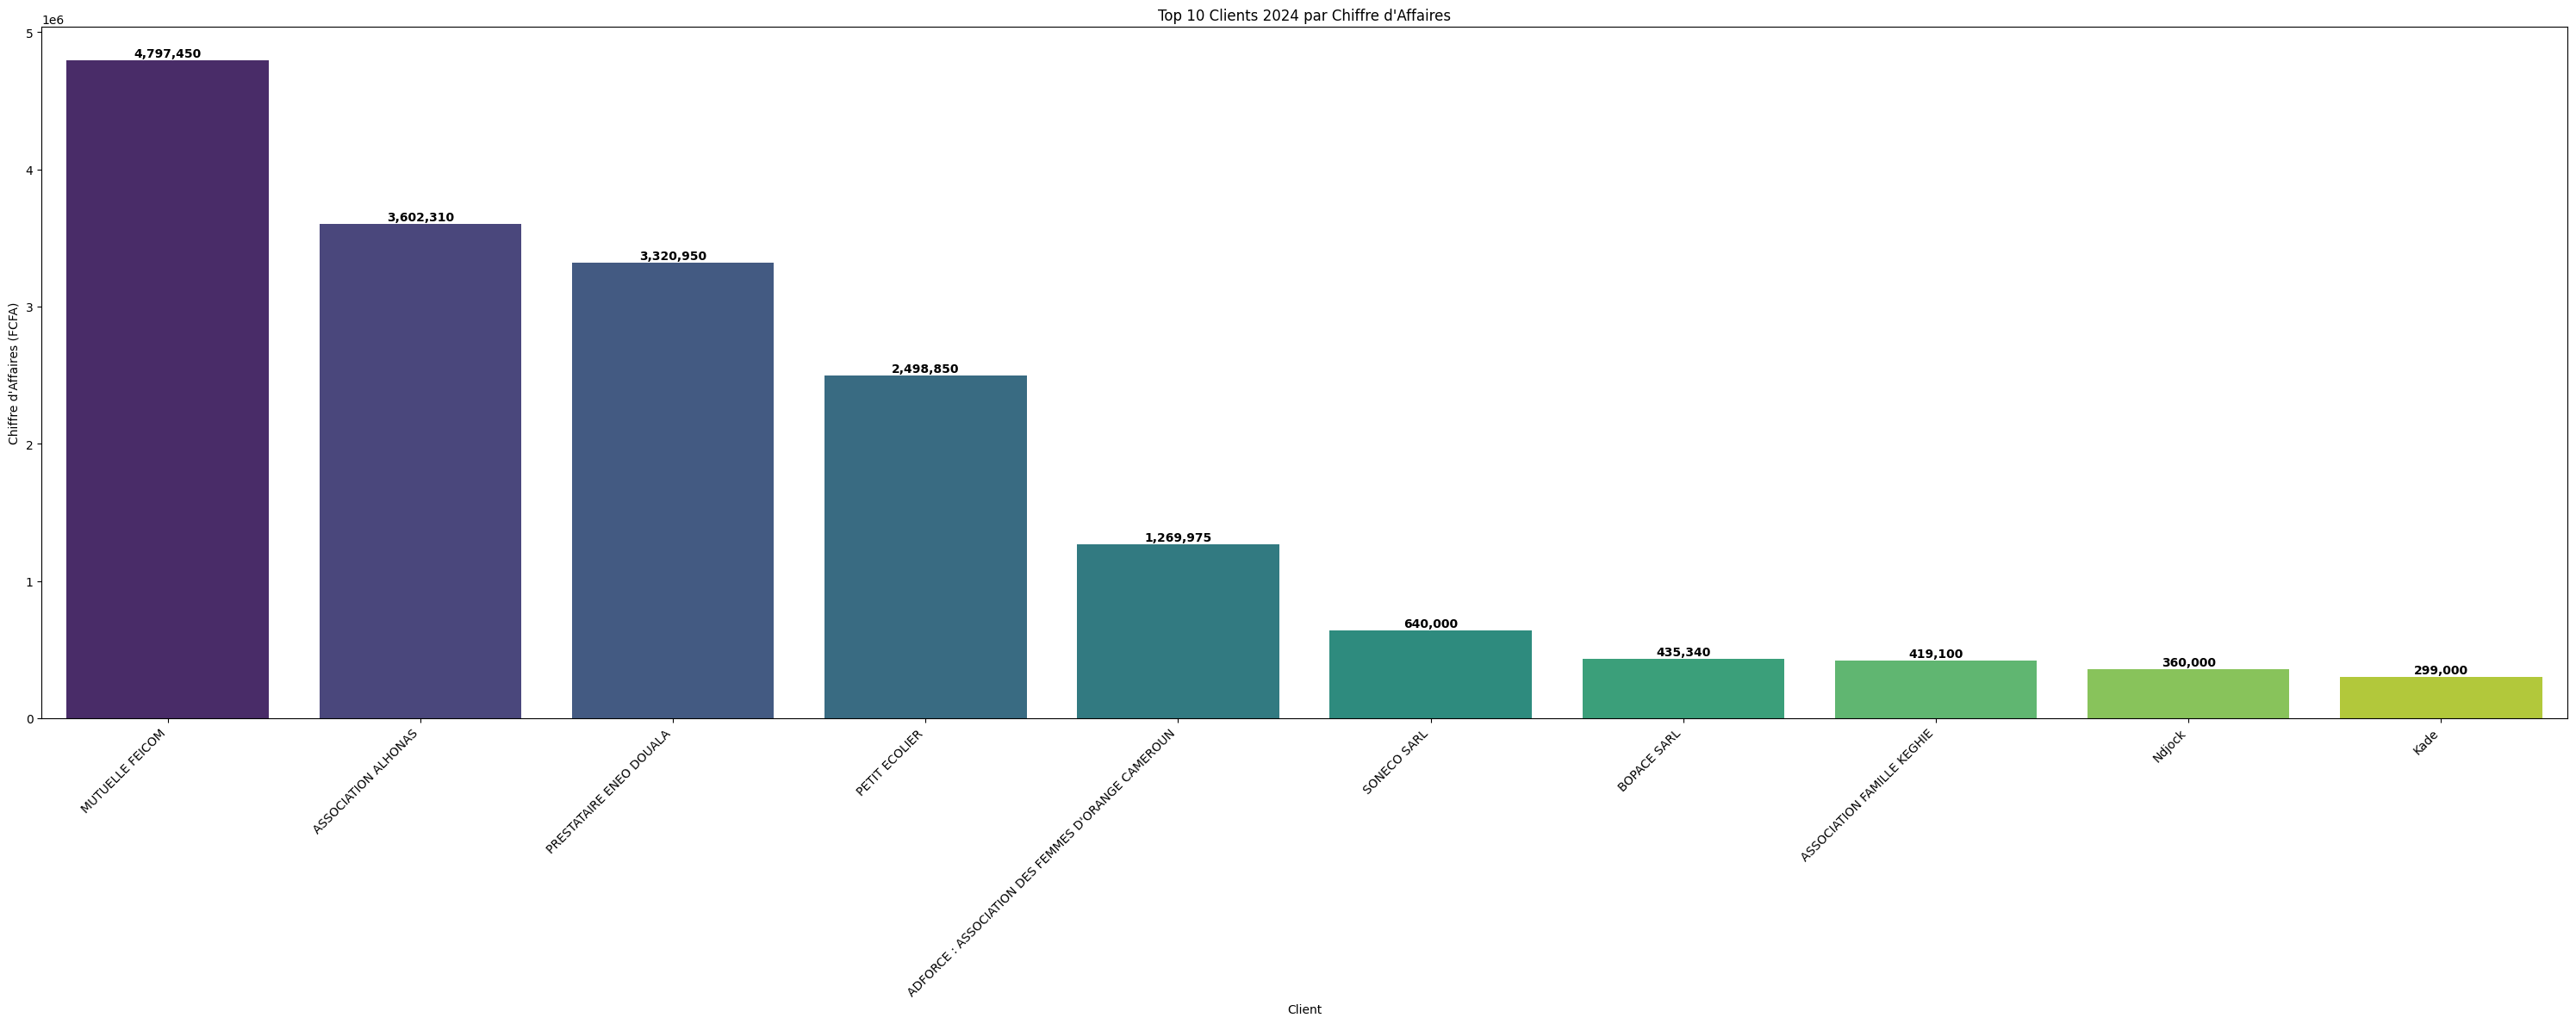

In [62]:
# 2. Top 10 clients par chiffre d'affaires
top_clients = ca_par_ville.groupby("nom")["chiffre_affaire"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(30, 12))
ax2 = sns.barplot(x=top_clients.index, y=top_clients.values, palette="viridis")
plt.title("Top 10 Clients 2024 par Chiffre d'Affaires")
plt.xlabel("Client")
plt.ylabel("Chiffre d'Affaires (FCFA)")

for i, value in enumerate(top_clients.values):
    ax2.text(i, value + 5000, f"{value:,.0f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/1899027507.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax4 = sns.barplot(x=commandes_par_ville.index, y=commandes_par_ville.values, palette="viridis")


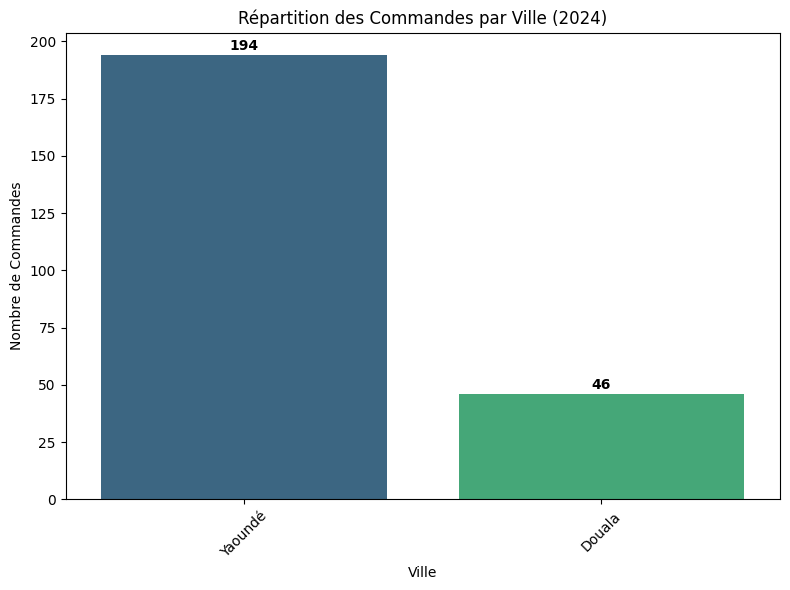

In [63]:
# 3. Répartition du nombre de commandes par ville
commandes_par_ville = ventes_2024["ville"].value_counts()
plt.figure(figsize=(8, 6))
ax4 = sns.barplot(x=commandes_par_ville.index, y=commandes_par_ville.values, palette="viridis")
plt.title("Répartition des Commandes par Ville (2024)")
plt.xlabel("Ville")
plt.ylabel("Nombre de Commandes")

for i, value in enumerate(commandes_par_ville.values):
    ax4.text(i, value + 1, f"{value:,}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **6. Analyse des ventes de Douala 2022**

Dans cette étape, on charge et consolide les ventes 2022 de Douala, en uniformisant les noms, numéros et adresses pour produire un ventes_2024.csv propre et exploitable pour les analyses.

### **6.1- Fusion des ventes de 2022**

In [64]:
# Configuration des chemins
VENTES_2022_DIR = BASE_DIR / "data" / "raw" / "Ventes_2022"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

In [65]:
# Colonnes standardisées pour la fusion finale 2022
COLUMNS_2022 = ["nom", "telephone", "commande", "montant", "adresse", "frais_livraison", "bon_fidelite", "ville"]

print("🔥 DÉMARRAGE - CONSOLIDATION VENTES 2022")
print(f"📂 Répertoire source: {VENTES_2022_DIR}")
print(f"📂 Répertoire sortie: {PROCESSED_DIR}")

🔥 DÉMARRAGE - CONSOLIDATION VENTES 2022
📂 Répertoire source: ../data/raw/Ventes_2022
📂 Répertoire sortie: ../data/processed


In [66]:
# Vérifier que le répertoire source existe
if not VENTES_2022_DIR.exists():
    print(f"❌ ERREUR: Le répertoire {VENTES_2022_DIR} n'existe pas!")
    exit(1)

In [67]:
# Mapping des filiales vers leurs villes pour 2022
FILIALES_VILLES_2022 = {
    "soneco sarl": "Yaoundé",
    "soccarema": "Douala", 
    "prestataire eneo douala": "Douala",
    "petit ecolier": "Yaoundé",
    "mutuelle feicom": "Yaoundé",
    "adforce": "Yaoundé",  # Association des femmes d'Orange Cameroun
    "association alhonas": "Yaoundé",
    "association famille keghie": "Yaoundé", 
    "bopace sarl": "Yaoundé",
    "yaoundé": "Yaoundé",
    "douala": "Douala",
    "ventes_2022_douala": "Douala"  # Pour le fichier existant
}

In [68]:
# Fonctions utilitaires de nettoyage 

def clean_name(nom):
    """Nettoie et standardise les noms de clients"""
    if pd.isna(nom) or str(nom).strip().lower() in ["", "nan", "/", "--", "-"]:
        return "(None)"
    
    # Supprimer les titres civiques
    nom = re.sub(r"(mme\.?|mr\.?|m\.?|mlle\.?)", "", str(nom), flags=re.IGNORECASE)
    
    # Garder seulement les caractères alphanumériques, espaces, tirets et accents français
    nom = re.sub(r"[^\w\s\-àâäéèêëîïôöùûüÿñç]", "", nom).strip().title()
    
    return nom if nom else "(None)"

def clean_phone(phone):
    """Nettoie les numéros de téléphone (supprime le .0 si besoin)"""
    if pd.isna(phone) or str(phone).strip() in ["", "nan", "/", "--", "-"]:
        return "(None)"
    
    phone_str = str(phone).strip()
    try:
        return str(int(float(phone_str))) if phone_str.replace('.', '', 1).isdigit() else phone_str
    except:
        return "(None)"

def clean_money(val):
    """Nettoie et extrait les montants numériques"""
    if pd.isna(val):
        return "0"
    
    # Extraire seulement les chiffres
    val_str = re.sub(r"[^\d]", "", str(val))
    return val_str if val_str else "0"

def clean_text_field(val):
    """Nettoie les champs texte génériques (adresse, commande, etc.)"""
    if pd.isna(val):
        return "(None)"
    val = str(val).strip()
    return "(None)" if val.lower() in ["", "nan", "/", "--", "-"] else val

def detect_ville_from_source_2022(source_file):
    """Détermine la ville en fonction du nom du fichier source pour 2022"""
    source_clean = source_file.lower().replace('.csv', '')
    
    # Recherche directe dans le mapping
    for key, ville in FILIALES_VILLES_2022.items():
        if key in source_clean:
            return ville
    
    # Par défaut Yaoundé si non trouvé
    return "Yaoundé"


def process_douala_2022_file(df, ville, filename):
    """Traite spécifiquement le fichier Ventes_2022_Douala.csv avec ses colonnes particulières"""
    df_std = pd.DataFrame()
    
    # Mapping spécifique pour le fichier 2022 Douala
    # Colonnes disponibles: DATE, NOM, TELEPHONE, LIEU DE LIVRAISON, COMMANDE, 
    # LIBRAIRIE F.SSEUR, FACTURE F.SSEUR, FACTURE BBS, MONTANT ENCAISSE, BENEFICES BBS
    
    # Nom
    if "NOM" in df.columns:
        df_std["nom"] = df["NOM"].apply(clean_name)
    else:
        df_std["nom"] = "(None)"
    
    # Téléphone
    if "TELEPHONE" in df.columns:
        df_std["telephone"] = df["TELEPHONE"].apply(clean_phone)
    else:
        df_std["telephone"] = "(None)"
    
    # Commande
    if "COMMANDE" in df.columns:
        df_std["commande"] = df["COMMANDE"].apply(clean_text_field)
    else:
        df_std["commande"] = "(None)"
    
    # Montant - utiliser MONTANT ENCAISSE ou FACTURE BBS
    montant_col = None
    if "MONTANT ENCAISSE" in df.columns:
        montant_col = "MONTANT ENCAISSE"
    elif "FACTURE BBS" in df.columns:
        montant_col = "FACTURE BBS"
    
    if montant_col:
        df_std["montant"] = df[montant_col].apply(clean_money)
    else:
        df_std["montant"] = "0"
    
    # Adresse - utiliser LIEU DE LIVRAISON
    if "LIEU DE LIVRAISON" in df.columns:
        df_std["adresse"] = df["LIEU DE LIVRAISON"].apply(clean_text_field)
    else:
        df_std["adresse"] = "(None)"
    
    # Frais de livraison - pas présent dans ce format
    df_std["frais_livraison"] = "0"
    
    # Bon de fidélité - pas présent dans ce format
    df_std["bon_fidelite"] = "0"
    
    # Ville
    df_std["ville"] = ville
    
    return df_std[COLUMNS_2022].copy()

def process_individual_file_2022(path):
    """Traite un fichier CSV individuel pour 2022"""
    print(f"  Traitement: {path.name}")
    
    try:
        # Lecture du fichier avec différents séparateurs possibles
        df = pd.read_csv(path, sep=None, engine="python", encoding='utf-8')
        
        if df.empty:
            print(f"⚠️  Fichier vide: {path.name}")
            return None
            
        print(f"     Lignes lues: {len(df)}")
        print(f"     Colonnes: {list(df.columns)}")
        
        # Standardisation des noms de colonnes
        df.columns = [col.strip() for col in df.columns]
        
        # Détection de la ville basée sur le nom du fichier
        ville_source = detect_ville_from_source_2022(path.name)
        print(f"      Ville détectée: {ville_source}")
        
        # Traitement spécifique selon le type de fichier
        if "ventes_2022_douala" in path.name.lower() or ("NOM" in df.columns and "TELEPHONE" in df.columns):
            # Fichier avec données clients détaillées (format 2022)
            return process_douala_2022_file(df, ville_source, path.name)
        else:
            # Fichiers de filiales avec montants globaux (comme en 2024)
            return process_filiale_file_2022(df, ville_source, path.name)
            
    except Exception as e:
        print(f"   ❌ Erreur avec {path.name}: {str(e)}")
        return None

def process_filiale_file_2022(df, ville, filename):
    """Traite les fichiers de filiales 2022 avec montants globaux"""
    df_std = pd.DataFrame()
    
    # Extraire le nom de la filiale du nom de fichier
    nom_filiale = filename.replace('.csv', '').upper()
    
    # Pour les filiales, on crée une seule ligne avec le montant total
    montant_total = "0"
    
    # Recherche du montant dans différentes colonnes possibles
    montant_cols = ["net a payer", "montant percu", "deja percu", "montant", "total"]
    for col in montant_cols:
        col_lower = col.lower()
        matching_cols = [c for c in df.columns if col_lower in c.lower()]
        if matching_cols:
            # Prendre la première valeur non nulle
            for val in df[matching_cols[0]]:
                if pd.notna(val) and str(val).strip() not in ["", "/", "nan"]:
                    montant_total = clean_money(val)
                    break
            break
    
    # Créer une ligne pour cette filiale
    df_std = pd.DataFrame({
        "nom": [nom_filiale],
        "telephone": ["(None)"],
        "commande": ["VENTE FILIALE"],
        "montant": [montant_total],
        "adresse": [f"FILIALE {ville}"],
        "frais_livraison": ["0"],
        "bon_fidelite": ["0"],
        "ville": [ville]
    })
    
    return df_std

In [69]:
# Liste pour stocker tous les DataFrames
all_ventes_2022 = []

# Récupération de tous les fichiers CSV
csv_files_2022 = list(VENTES_2022_DIR.glob("*.csv"))

if not csv_files_2022:
    print(f"❌ ERREUR: Aucun fichier CSV trouvé dans {VENTES_2022_DIR}")
    exit(1)

print(f"📋 Fichiers trouvés: {len(csv_files_2022)}")
for f in csv_files_2022:
    print(f"   • {f.name}")
    
print()

📋 Fichiers trouvés: 1
   • Douala.csv



In [70]:
# Traitement de chaque fichier
for path in csv_files_2022:
    df_processed = process_individual_file_2022(path)
    
    if df_processed is not None:
        all_ventes_2022.append(df_processed)
        print(f"      Succès: {len(df_processed)} lignes standardisées")
        
        # Affichage des statistiques par ville
        if len(df_processed) > 0:
            villes_detectees = df_processed["ville"].value_counts()
            print(f"  Villes: {dict(villes_detectees)}")
    
    print()

  Traitement: Douala.csv
     Lignes lues: 102
     Colonnes: ['DATE', 'NOM', 'TELEPHONE', 'LIEU DE LIVRAISON', 'COMMANDE', 'LIBRAIRIE F.SSEUR', 'FACTURE F.SSEUR', 'FACTURE BBS', 'MONTANT ENCAISSE', 'BENEFICES\n']
      Ville détectée: Douala
      Succès: 102 lignes standardisées
  Villes: {'Douala': np.int64(102)}



In [71]:
print(f"Fichiers traités avec succès: {len(all_ventes_2022)}")

if not all_ventes_2022:
    print("❌ ERREUR: Aucun fichier traité avec succès!")
    exit(1)

# Fusion de tous les DataFrames
ventes_2022 = pd.concat(all_ventes_2022, ignore_index=True)

Fichiers traités avec succès: 1


In [72]:
# === RÉSUMÉ FINAL 2022 ===

print(f"\n RÉSUMÉ FINAL - VENTES 2022:")
print(f"   \n• Total lignes: {len(ventes_2022):,}")
print(f"   \n• Colonnes: {list(ventes_2022.columns)}")
print(f"   \n• Villes uniques: {sorted(ventes_2022['ville'].unique())}")


 RÉSUMÉ FINAL - VENTES 2022:
   
• Total lignes: 102
   
• Colonnes: ['nom', 'telephone', 'commande', 'montant', 'adresse', 'frais_livraison', 'bon_fidelite', 'ville']
   
• Villes uniques: ['Douala']


In [73]:
# Vérification des valeurs manquantes
none_count = (ventes_2022["ville"] == "(None)").sum()
print(f"   • Villes avec valeur '(None)': {none_count}")

   • Villes avec valeur '(None)': 0


In [74]:
print(f"\n  RÉPARTITION PAR VILLE:")
ville_counts = ventes_2022["ville"].value_counts()
for ville, count in ville_counts.items():
    print(f"   • {ville}: {count:,} ventes")


  RÉPARTITION PAR VILLE:
   • Douala: 102 ventes


In [75]:
# Montant total général
montant_general = ventes_2022["montant"].apply(lambda x: int(x) if x.isdigit() else 0).sum()
print(f"\n  MONTANT TOTAL 2022: {montant_general:,} FCFA")


  MONTANT TOTAL 2022: 3,540,800 FCFA


In [76]:
# Sauvegarde
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
output_path_2022 = PROCESSED_DIR / "ventes_2022.csv"
ventes_2022.to_csv(output_path_2022, index=False, encoding='utf-8')
print(f"\n  Fichier sauvegardé: {output_path_2022}")

print("\n🎉 CONSOLIDATION 2022 TERMINÉE AVEC SUCCÈS!")


  Fichier sauvegardé: ../data/processed/ventes_2022.csv

🎉 CONSOLIDATION 2022 TERMINÉE AVEC SUCCÈS!


### **6.2 - EXTRACTION DE LA BASE CLIENTS 2022**


In [77]:
VENTES_2022_PATH = PROCESSED_DIR / "ventes_2022.csv"
CLIENTS_2022_PATH = PROCESSED_DIR / "clients_2022.csv"

ventes_2022_df = pd.read_csv(VENTES_2022_PATH) # Chargement du fichier ventes_2022.csv
print(f"✅ {len(ventes_2022_df)} lignes chargées")

✅ 102 lignes chargées


In [78]:
# Extraction des téléphones secondaires
def split_telephones(telephone):
    if pd.isna(telephone):
        return telephone, None
    parts = re.split(r"[\-/]", str(telephone))
    parts = [p.strip() for p in parts if p.strip() and p.strip().lower() != "none"]
    if len(parts) == 1:
        return parts[0], None
    return parts[0], parts[1]

ventes_2022_df[["telephone_principal", "telephone_secondaire"]] = ventes_2022_df.apply(
    lambda row: pd.Series(split_telephones(row["telephone"])), axis=1
)

# Filtrer uniquement les lignes avec numéro principal valide
ventes_2022_df = ventes_2022_df[
    ventes_2022_df["telephone_principal"].notna() &
    (ventes_2022_df["telephone_principal"] != "(None)")
]

In [79]:
# Grouper les clients par téléphone principal
print("👥 Construction de la base clients 2022...")
clients_2022_df = ventes_2022_df.groupby("telephone_principal").agg({
    "nom": lambda x: sorted(set(x)),
    "telephone_secondaire": lambda x: next((v for v in x if pd.notna(v)), None),
    "commande": lambda x: ", ".join(sorted(set(x.dropna()))),
    "adresse": lambda x: next((v for v in x if pd.notna(v) and v != "(None)"), "(None)"),
    "ville": lambda x: next((v for v in x if pd.notna(v) and v != "(None)"), "(None)"),
    "telephone_principal": "count"
}).rename(columns={
    "nom": "alias",
    "telephone_secondaire": "telephone_secondaire",
    "commande": "commande",
    "adresse": "adresse",
    "ville": "ville",
    "telephone_principal": "nb_commandes"
}).reset_index().rename(columns={"telephone_principal": "telephone"})

👥 Construction de la base clients 2022...


In [80]:
# Définir le nom principal comme le premier alias
clients_2022_df["nom"] = clients_2022_df["alias"].apply(lambda x: x[0] if isinstance(x, list) and x else "")
clients_2022_df["alias"] = clients_2022_df.apply(
    lambda row: ", ".join([a for a in row["alias"] if a != row["nom"]]),
    axis=1
)

# Réorganiser les colonnes
clients_2022_df = clients_2022_df[[
    "nom", "alias", "telephone", "telephone_secondaire",
    "commande", "adresse", "ville", "nb_commandes"
]].sort_values("nom")

In [81]:
# Sauvegarde du fichier
clients_2022_df.to_csv(CLIENTS_2022_PATH, index=False, encoding='utf-8')
print(f"📁 Fichier sauvegardé → {CLIENTS_2022_PATH}")

📁 Fichier sauvegardé → ../data/processed/clients_2022.csv


In [82]:
print(f"✅ {len(clients_2022_df)} clients extraits")
print("\n📌  ÉCHANTILLON :")
print(clients_2022_df.head().to_string(index=False))

✅ 84 clients extraits

📌  ÉCHANTILLON :
       nom alias telephone telephone_secondaire             commande      adresse  ville  nb_commandes
Ada Carole       677769841                 None   CE1, CM1 & Class 6     Bonabéri Douala             1
      Affo       678935877                 None          Fournitures    Bonapriso Douala             1
  Anderson       690501397                 None              CP, SIL      Bonanjo Douala             2
     Annie       677495411                 None Class 1,4, SIL & CE2       Makèpe Douala             1
     Arcel       694851306                 None   Class 1, Nursery 2 Bonamoussadi Douala             2


In [83]:
# Sauvegarde
clients_2022_df.to_csv(CLIENTS_2022_PATH, index=False, encoding='utf-8')
print(f"💾 Fichier sauvegardé → {CLIENTS_2022_PATH}")

💾 Fichier sauvegardé → ../data/processed/clients_2022.csv


### **6.3 - Analyse des performances commerciales 2022**

In [84]:
# Configuration des graphiques
plt.style.use('default')
sns.set_palette("viridis")

# Préparation des données pour l'analyse
ca_par_ville_2022 = ventes_2022.copy()
ca_par_ville_2022["montant"] = ca_par_ville_2022["montant"].apply(lambda x: int(x) if str(x).isdigit() else 0)
ca_par_ville_2022["frais_livraison"] = ca_par_ville_2022["frais_livraison"].apply(lambda x: int(x) if str(x).isdigit() else 0)
ca_par_ville_2022["chiffre_affaire"] = ca_par_ville_2022["montant"] + ca_par_ville_2022["frais_livraison"]

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/3702559618.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=ca_by_ville_2022.index, y=ca_by_ville_2022.values, palette="viridis")


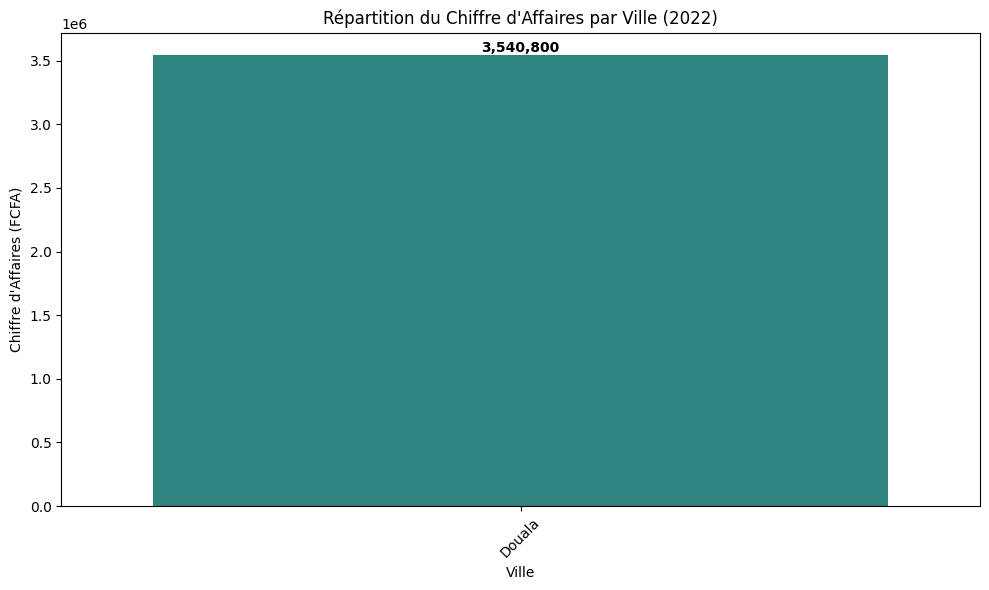

In [85]:
# Graphique 1 - Répartition du chiffre d'affaires par ville 2022
ca_by_ville_2022 = ca_par_ville_2022.groupby("ville")["chiffre_affaire"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x=ca_by_ville_2022.index, y=ca_by_ville_2022.values, palette="viridis")
plt.title("Répartition du Chiffre d'Affaires par Ville (2022)")
plt.xlabel("Ville")
plt.ylabel("Chiffre d'Affaires (FCFA)")

for i, value in enumerate(ca_by_ville_2022.values):
    ax1.text(i, value + 5000, f"{value:,.0f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/177298246.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=top_clients_2022.index, y=top_clients_2022.values, palette="viridis")


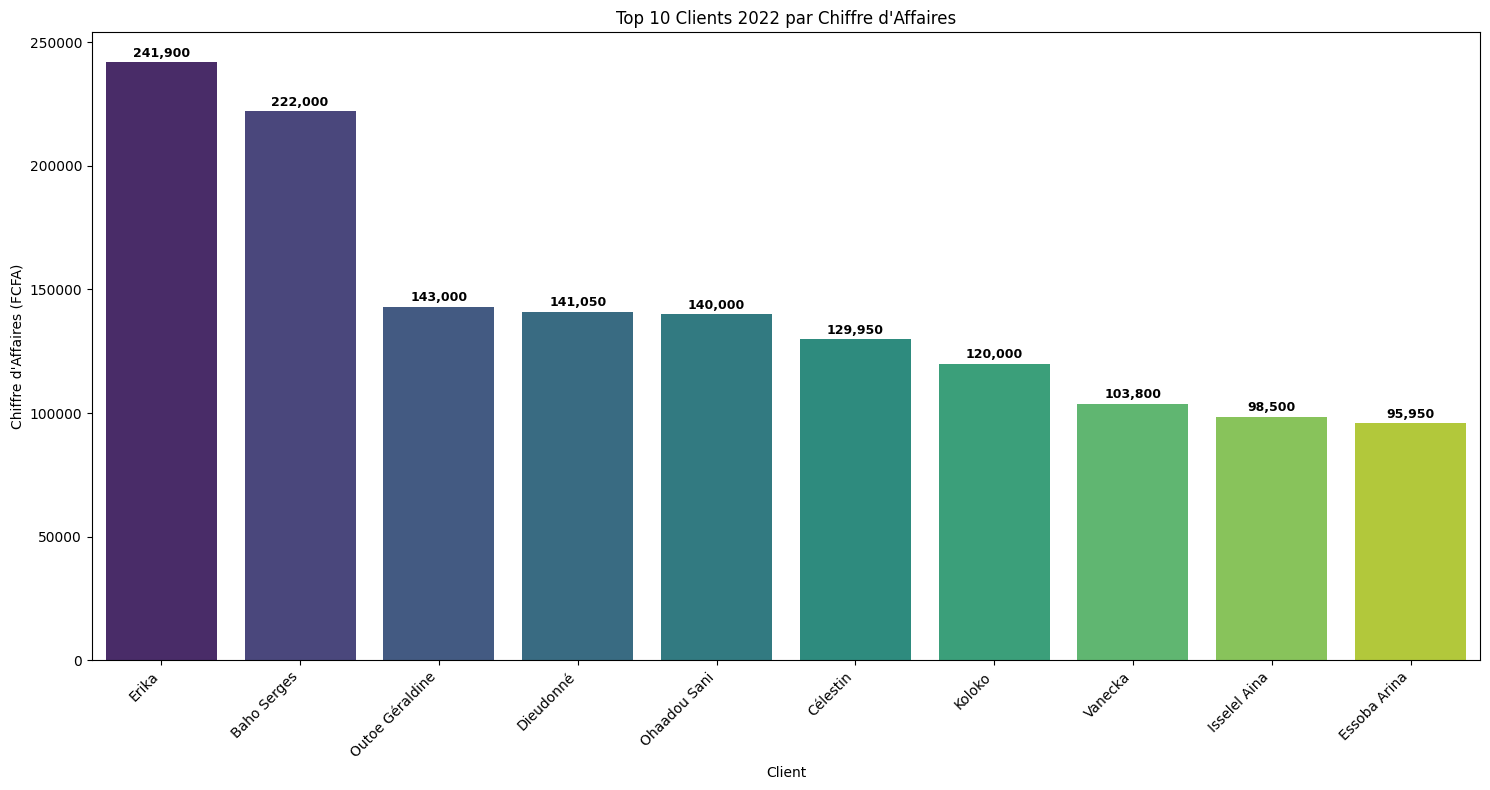

In [86]:
# Graphique 2 - Top 10 clients par chiffre d'affaires 2022
top_clients_2022 = ca_par_ville_2022.groupby("nom")["chiffre_affaire"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(15, 8))
ax2 = sns.barplot(x=top_clients_2022.index, y=top_clients_2022.values, palette="viridis")
plt.title("Top 10 Clients 2022 par Chiffre d'Affaires")
plt.xlabel("Client")
plt.ylabel("Chiffre d'Affaires (FCFA)")

for i, value in enumerate(top_clients_2022.values):
    ax2.text(i, value + 1000, f"{value:,.0f}", ha='center', va='bottom', fontsize=9, weight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/1n/d3tj9kpd549_ytmqz2cjc6rc0000gn/T/ipykernel_39234/568607342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(x=commandes_par_ville_2022.index, y=commandes_par_ville_2022.values, palette="viridis")


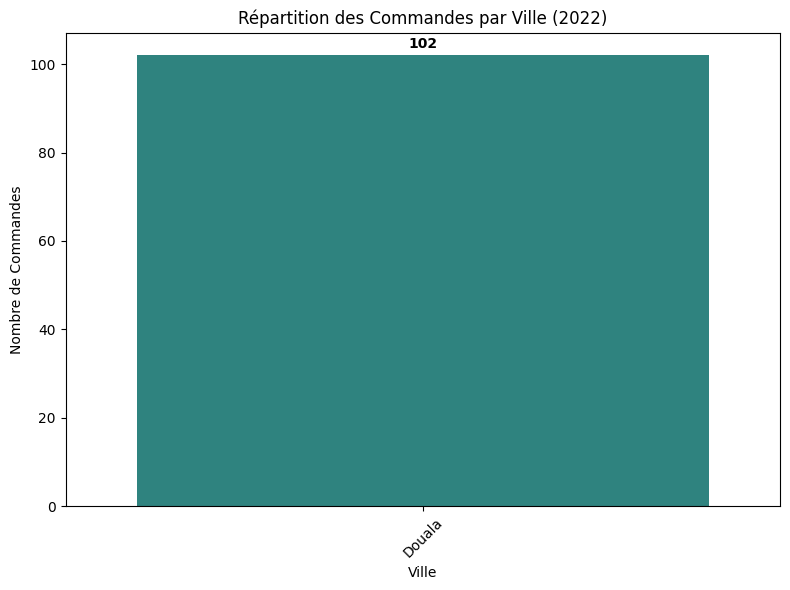

In [87]:
# Graphique 3 - Répartition du nombre de commandes par ville 2022
commandes_par_ville_2022 = ventes_2022["ville"].value_counts()
plt.figure(figsize=(8, 6))
ax3 = sns.barplot(x=commandes_par_ville_2022.index, y=commandes_par_ville_2022.values, palette="viridis")
plt.title("Répartition des Commandes par Ville (2022)")
plt.xlabel("Ville")
plt.ylabel("Nombre de Commandes")

for i, value in enumerate(commandes_par_ville_2022.values):
    ax3.text(i, value + 1, f"{value:,}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [88]:
# Statistiques finales
print(f"\n📈 STATISTIQUES FINALES 2022:")
print(f"   \n• Nombre total de ventes: {len(ventes_2022):,}")
print(f"   \n• Nombre de clients uniques: {len(clients_2022_df):,}")
print(f"   \n• Chiffre d'affaires total: {ca_by_ville_2022.sum():,} FCFA")
print(f"   \n• Chiffre d'affaires moyen par vente: {ca_by_ville_2022.sum() / len(ventes_2022):,.0f} FCFA")
print(f"   \n• Ville principale: {ca_by_ville_2022.index[0]} ({ca_by_ville_2022.iloc[0]:,} FCFA)")


📈 STATISTIQUES FINALES 2022:
   
• Nombre total de ventes: 102
   
• Nombre de clients uniques: 84
   
• Chiffre d'affaires total: 3,540,800 FCFA
   
• Chiffre d'affaires moyen par vente: 34,714 FCFA
   
• Ville principale: Douala (3,540,800 FCFA)
